<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>

</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

# Projet 4 A MACHINE LEARNING EN PYTHON

**Résumé**: Exploration puis modélisation de données climatiques en utilisant Python et la librairie [Scikit-learn](http://scikit-learn.org/stable/#). L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par différentes méthodes: régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [k plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC. Itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision. Ce calepin vient compléter l'[étude faite avec R](http://www.math.univ-toulouse.fr/~besse/Wikistat/Notebooks/Notebook-R-Ozone.html) pour en comparer les deux approches.

**Avertissement** 

* Ce calepin complète [celui en R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) afin de comparer les performances respectives des deux environnements: complétude des résultats et efficacité du code. Les explications sont plus sommaires dans ce tutoriel qui est en principe exécuté *après* ou parallèlement à celui réalisé en R.  
* Comme pour R il est *découpé en 5 séances* de travaux dirigés *syncronisées* avec le cours d'apprentissage automatique. 
* Réfléchir aux réponses aux questions marquées **Q** issues du sujet d'examen.
* Toutes les options n'ont pas été testées et certaines sont posées en **exercice**.

## Introduction

<FONT COLOR="Red"> Pour la REGRESSION : au lieu d'utiliser la norme $L^2$ pour le calcul du MSE, pour l'erreur de généralisation, on peut utiliser ce que météo France utilise i.e MAPE=$\frac{100}{n} \sum_{i=1}^{n} \frac{|Y_i-\hat{Y}_i|}{Y_i+1}$ FAIRE ATTENTION !

In [243]:
def MAPE(y_true, y_pred) : #fonction propre à météo france, permettant de calculer le MSE dans notre cas 
    n = len(y_true) 
    res = 0
    for i in range(n) :
        res += np.abs(y_true[i]-y_pred[i])/(y_true[i]+1)
    return res*(100/n)

In [244]:
def purity(crosstab): #fonction prenant une table de contingence en entrée et calculant la pureté, propre à la classification
    cross=crosstab.to_numpy()
    purity = 0.
    for cluster in range(cross.shape[1]):  # clusters are along columns
        purity += np.max(cross[ cluster,:])
    return purity/np.sum(cross)

In [245]:
# fonction qui prend en entrée :
# - les prédictions en regression (rain_reg) et en classification (rain_class)
# - les résultats attendus pour les sets de test en classification (Yb_test)
# La fonction associe à la prédiction en regression la classe de pluie correspondante puis calcule le 
# NMI et le score de Mallow. Les seuils sont : 
# - no_rain si rain = 0
# - low_rain si 0 < rain <= 2
# - high rain si rain > 2

from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import normalized_mutual_info_score 

def compare_reg_class(rain_reg, rain_class,Yb_test) : 
    rain_reg = np.array(rain_reg)
    rain_class = np.array(rain_class)
    rain_comp = np.array([''] * np.size(rain_reg), dtype="object") 
    ind_no = np.where(rain_reg==0)[0]
    ind_low =  list(set(np.where(rain_reg>0)[0])&set(np.where(rain_reg<=2)[0]))
    ind_high = np.where(rain_reg>2)[0]
    
    rain_comp[ind_no] = 'no_rain'
    rain_comp[ind_low] = 'low_rain'
    rain_comp[ind_high] = 'high_rain'
    
    #résultat regression :
    NMIr = normalized_mutual_info_score(rain_comp,Yb_test)
    Mallowr = fowlkes_mallows_score(rain_comp,Yb_test)
    print('NMI regression : ', NMIr)
    print('Mallow regression : ', Mallowr)
    
    #résultat classification : 
    NMIb = normalized_mutual_info_score(rain_class,Yb_test)
    Mallowb = fowlkes_mallows_score(rain_class,Yb_test)
    print('NMI classification : ', NMIb)
    print('Mallow classification : ', Mallowb)
    
    #comparaison des deux résultats : 
    NMI = normalized_mutual_info_score(rain_comp,rain_class)
    Mallow = fowlkes_mallows_score(rain_comp,rain_class)
    print('NMI classification : ', NMI)
    print('Mallow classification : ', Mallow)
    
    return NMIr,Mallowr,NMIb,Mallowb,NMI,Mallow

# <FONT COLOR="Red">Épisode 1</font>
<FONT COLOR="Red">02-09</font>

## Prise en compte des données

Présentation du jeu de données : La population étudiée dans ce jeu de données est l’ensemble des observations météorologiques d'une station de Météo France. Notre échantillon se compose de 688 observations, entre le 2 janvier 2016 et 30 décembre 2017. Le jeu de données comprend 18 variables statistiques (dont 2 qualitatives et 16 quantitatives). Concernant les variables qualitatives, la date est qualitative ordinale avec 688 modalités, la variable rain_class a 4 modalités (1: high_rain, 2:low_rain, 3:no_rain). 

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

PARAMETRES METEOROLOGIQUES OBSERVES LE JOUR J:
* **date** : date du jour actuel ;
* **ff** : vitesse du vent (en $m.s^{-1}$);
* **t** :température (en Kelvin K);
* **td** : point de rosée (en K) ;
* **hu** : l'humidité (en %);
* **dd** : direction du vent (en degrés) ;
* **precip** : quantité totale des précipitations ;

PREVISIONS METEOS DU JOUR SUIVANT :
* **ws_arome** : vitesse du vent (en $m.s^{-1}$);
* **p3031_arome** : direction du vent (en degrés);
* **u10_arome**: composantes du vent d'ouest à est prise à 10m de hauteur (en $m.s^{-1}$);
* **vu10_arome**:composantes du vent du sud au nord prise à 10m de hauteur (en $m.s^{-1}$);
* **t2m_arome**: température à 2mètres du sol (K);
* **d2m_arome**: point de rosée à 2m du sol(K);
* **r_arome**: humidité (en %) ;
* **tp_arome**: quantité totale de précipitations ($kg.m^{−2}$);
* **msl_arome**: pression atmosphérique (en P a);

VARIABLES REPONSE
* **rain** : quantité totale de précipitation le jour suivant $kg.m^{−2}$;
* **rain_class**: catégorie de précipitations : -no_rain (si rain=0), -low_rain (si 0<rain<2), -high_rain (si rain>2)

## 1. Chargement et mise en forme des données

In [246]:
#!pip install "pydotplus"

In [247]:
#chargement des librairies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log
from pandas.plotting import scatter_matrix
#! pip install pyensae 
import pyensae
from pyensae.graphhelper import Corrplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from statsmodels.graphics.mosaicplot import mosaic #faire une mosaic
from pandas.plotting import scatter_matrix
from pyensae.graphhelper import Corrplot

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import scale
from sklearn.cluster  import  KMeans
from  sklearn.metrics  import confusion_matrix
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LassoLarsCV
from itertools import cycle

from sklearn.linear_model import lasso_path
from sklearn.linear_model import LogisticRegression
import statsmodels as sm

from sklearn.tree import export_graphviz
import six
from six import StringIO  
import pydotplus
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_predict, KFold
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

In [248]:
# Lecture des données
## Charger les données ou les lire directement en précisant le chemin
path=""
meteo=pd.read_csv("rain_project.txt",delimiter=" ",header=0)
del(meteo["Id"]) #supprimer la colonne Id
# Vérification du contenu
meteo.head()

tparome_original=meteo["tp_arome"]
meteorain_original=meteo["rain"]

Ce qui suit permet d'affecter le bon type aux variables.

In [249]:
meteo["rain_class"]=pd.Categorical(meteo["rain_class"],ordered=False)
meteo.dtypes
meteo.date=pd.to_datetime(meteo.date)

print("date de début", meteo["date"].min(), "date de fin", meteo["date"].max())
#meteo['month'] = meteo['date'].dt.month 
meteo["date"] = meteo["date"].dt.month_name() #transforme la valeur date en une variable mois 
#print(meteo.dtypes)

date de début 2016-01-02 00:00:00 date de fin 2017-12-30 00:00:00


In [250]:
meteo.describe()
meteo.date

1          June
2         March
3          July
4           May
5      February
         ...   
726       April
727      August
728         May
729        June
730       April
Name: date, Length: 688, dtype: object

## 2. Analyse Unidimensionnelle

### Analyse proposée par thème :  

1. Imput :

- Les variables relatives à la vitesse du vent (ff_mod, ws_arome_mod) 
- les variables relatives aux précipitations (precip_mod et tp_arome)
- Les variables relatives à la température et au point de rosée (t_mod, td_mod, t2m_arome_mod et d2m_arome_mod)
- Les variables relatives à la direction du vent (dd_mod, p3031_arome_mod, u10_arome, v10_arome)
- Les variables relatives à l'humidité (hu et r_arome)
- pression atmosphérique (msl arome)

2. Output : 

- rain et rain class 


Pour chaque variable 

- tracer histogramme (ou regarder ci-dessus mais c'est un peu petit) + fonction de répartition + boxplot

- ou pie chart et barplot si variable qualitative 

- donner une interprétation de la distribution.

Même si les données ne présentent pas de défauts particuliers, une étude exploratoire préliminaire est indispensable afin de s'assurer le leur bonne cohérence, proposer d'éventuelles transformations et analyser les structures de corrélations ou plus généralement de liaisons entre les variables, de groupes des individus ou observations.

array([<AxesSubplot:ylabel='rain_class'>], dtype=object)

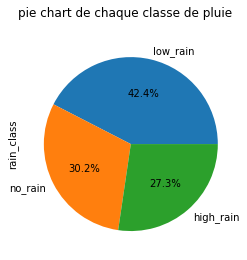

In [251]:
meteo['rain_class'].value_counts().plot.pie(subplots=True, title="pie chart de chaque classe de pluie", autopct='%1.1f%%')

(<Figure size 432x288 with 3 Axes>,
 {('April', 'low_rain'): (0.0, 0.0, 0.07301884712884381, 0.48731725602898907),
  ('April', 'high_rain'): (0.0,
   0.4906285143071348,
   0.07301884712884381,
   0.14994377108584275),
  ('April', 'no_rain'): (0.0,
   0.6438835436711232,
   0.07301884712884381,
   0.3561164563288767),
  ('August', 'low_rain'): (0.07775818362173481,
   0.0,
   0.07577427532238509,
   0.5237808549066826),
  ('August', 'high_rain'): (0.07775818362173481,
   0.5270921131848283,
   0.07577427532238509,
   0.1444912703190849),
  ('August', 'no_rain'): (0.07775818362173481,
   0.6748946417820589,
   0.07577427532238509,
   0.32510535821794095),
  ('December', 'low_rain'): (0.1582717954370109,
   0.0,
   0.07577427532238509,
   0.505719446116797),
  ('December', 'high_rain'): (0.1582717954370109,
   0.5090307043949427,
   0.07577427532238509,
   0.34316676700782656),
  ('December', 'no_rain'): (0.1582717954370109,
   0.855508729680915,
   0.07577427532238509,
   0.144491270319

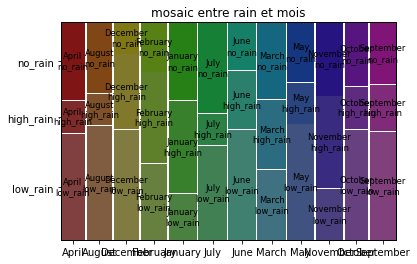

In [252]:
mosaic(meteo, ['date', 'rain_class'],statistic=False, title="mosaic entre rain et mois")

<FONT COLOR="blue"> Parmi les classes de précipitations de l'échantillon, 42.4% correspondent à des faibles précipitations, 30,2% correspondent à des précipitations nulles et 27,3% à des précipitations importantes. 

Ainsi, on peut voir que la majorité des observations de Météo france correspondent à des jours sans précépitation ou avec très peu de précipitations. Dans moins de 30% des jours, il y a de très fortes précipitations. 

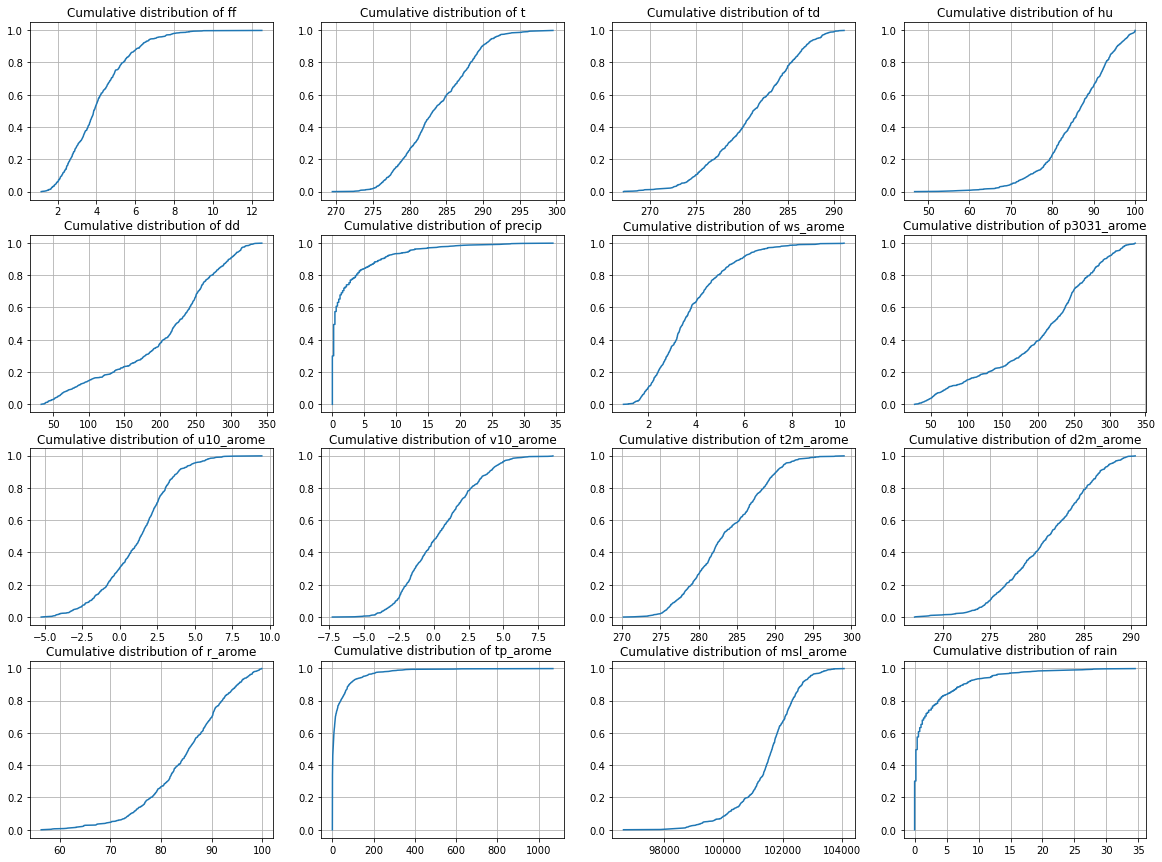

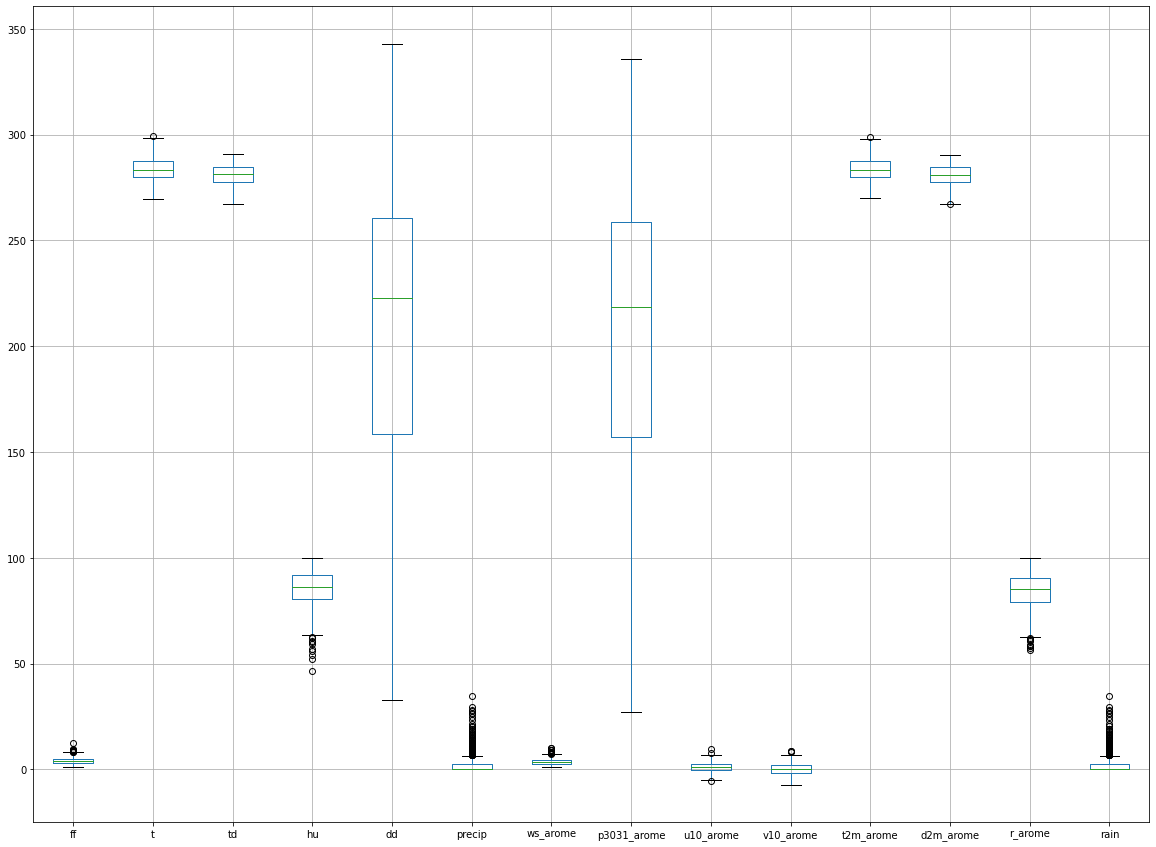

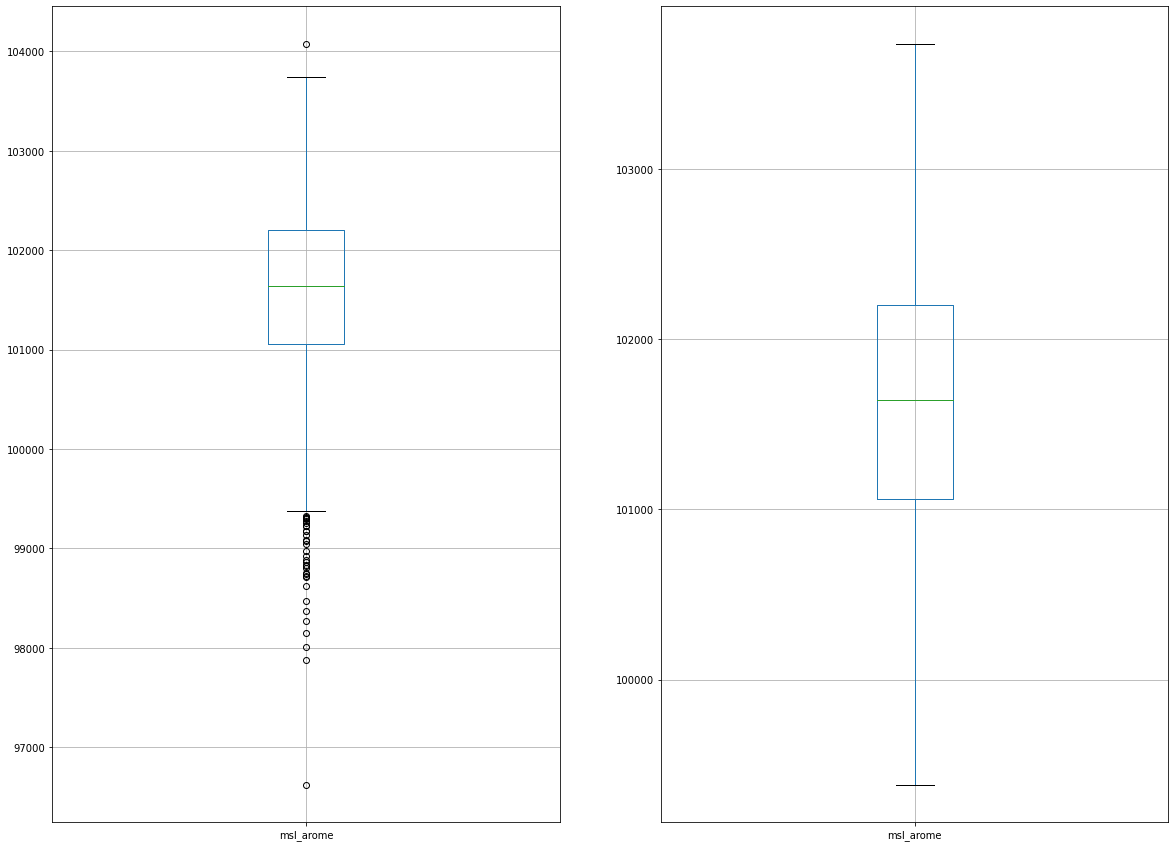

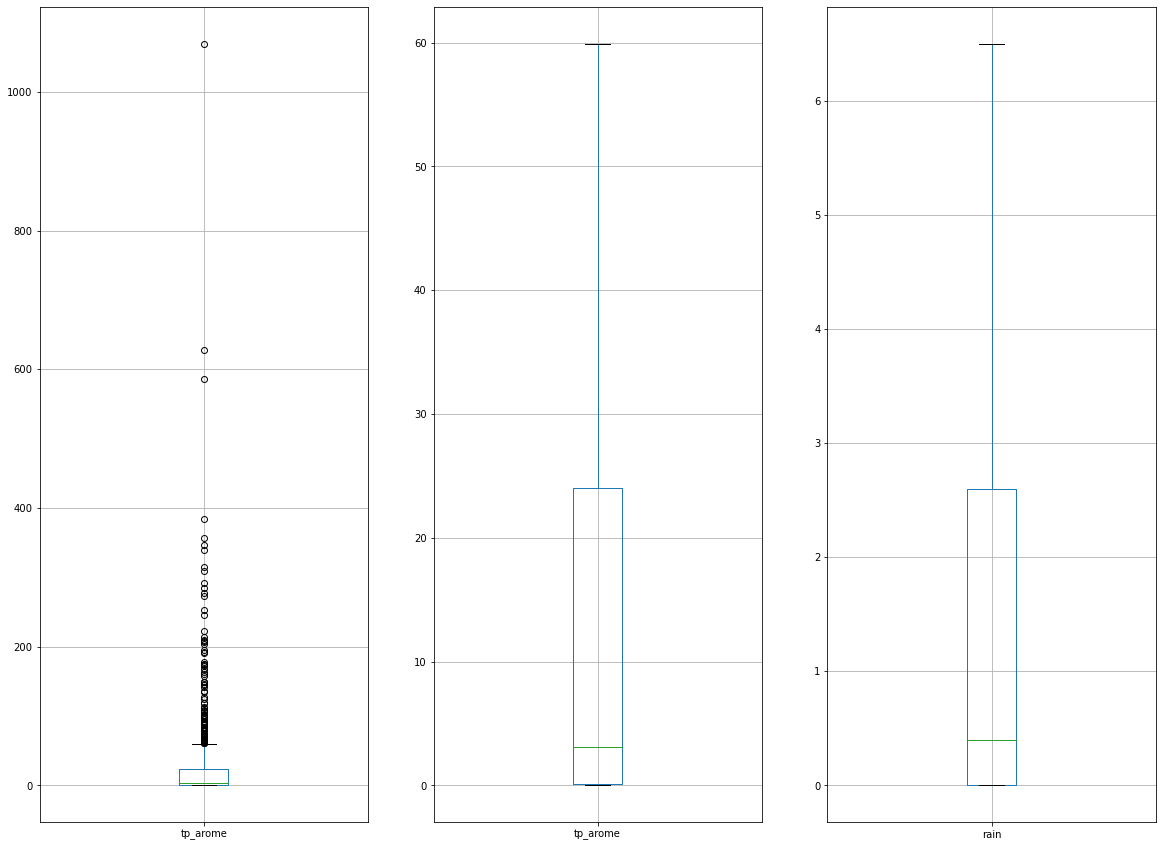

In [253]:
#boxplot des variables quantitatives et distribution 
i=1
fig = plt.figure(figsize=(20, 15))
for x in ["ff", "t", "td", "hu", "dd","precip", "ws_arome", "p3031_arome", "u10_arome", "v10_arome", "t2m_arome", "d2m_arome", "r_arome", "tp_arome","msl_arome","rain"]:
    plt.subplot(4,4, i)
    i+=1
    X2 = np.sort(meteo[x])
    N=len(X2)
    F2 = np.array(range(N))/float(N)
    plt.plot(X2, F2)
    plt.grid()
    plt.title('Cumulative distribution of '+str(x))
    
fig2 = plt.figure(figsize=(20, 15))
boxplot = meteo.boxplot(column=["ff", "t", "td", "hu", "dd","precip", "ws_arome", "p3031_arome", "u10_arome", "v10_arome", "t2m_arome", "d2m_arome", "r_arome","rain"])
fig3 = plt.figure(figsize=(20, 15))
plt.subplot(1,2,1)
boxplot2 = meteo.boxplot(column=["msl_arome"])
plt.subplot(1,2,2)
boxplot2 = meteo.boxplot(column=["msl_arome"], showfliers=False)

fig3 = plt.figure(figsize=(20, 15))
plt.subplot(1,3,1)
boxplot2 = meteo.boxplot(column=["tp_arome"])
plt.subplot(1,3,2)
boxplot2 = meteo.boxplot(column=["tp_arome"], showfliers=False)
plt.subplot(1,3,3)
boxplot2 = meteo.boxplot(column=["rain"], showfliers=False)



<FONT COLOR="blue"> Tout d'abord on voit que si on affiche toutes les variables sur un même boxplot il est illisible car les ordres de grandeur sont très différents, ainsi que les unités. 
On constate que les variables tp arome et msl_arome ont beaucoup d'outliers. Il s'agit de variables qui sont prédites par l'algorithme de Météo France. On voit en regardant tp arome qu'en enlevant les outliers, la médiane est 10 fois supérieure que pour rain la vraie quantité de pluie. Les prévisions ont donc tendance à surestimer les précipitations. De plus, on voit que ces deux variables ont une fonction de répartition similaire en termes de tendances, seules les valeurs sont différentes. 

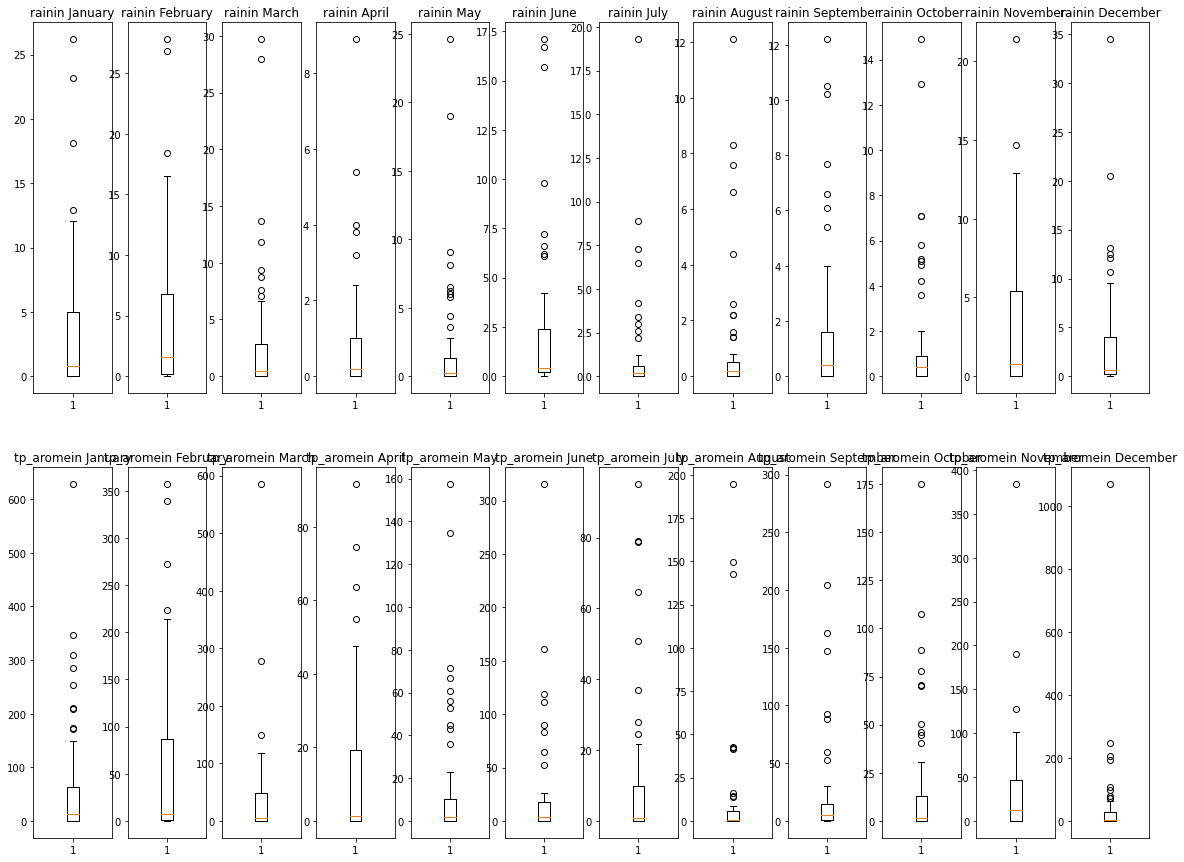

In [254]:
#biplot rain en fonction du mois, et tp_arome en fonction du mois
j=1
fig = plt.figure(figsize=(20, 15))
v=-1
for h in ["rain", "tp_arome"]:
    v+=1
    j=1
    for i in ["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]:
        plt.subplot(2,12,j+v*12)
        reqd_Index = np.where(meteo["date"] ==i)
        a=list(meteo[h])
        b=np.zeros((len(a),1))
        b[:,0]=a
        j+=1
        plt.title(str(h) +"in " + str(i))
        plt.boxplot(b[reqd_Index])

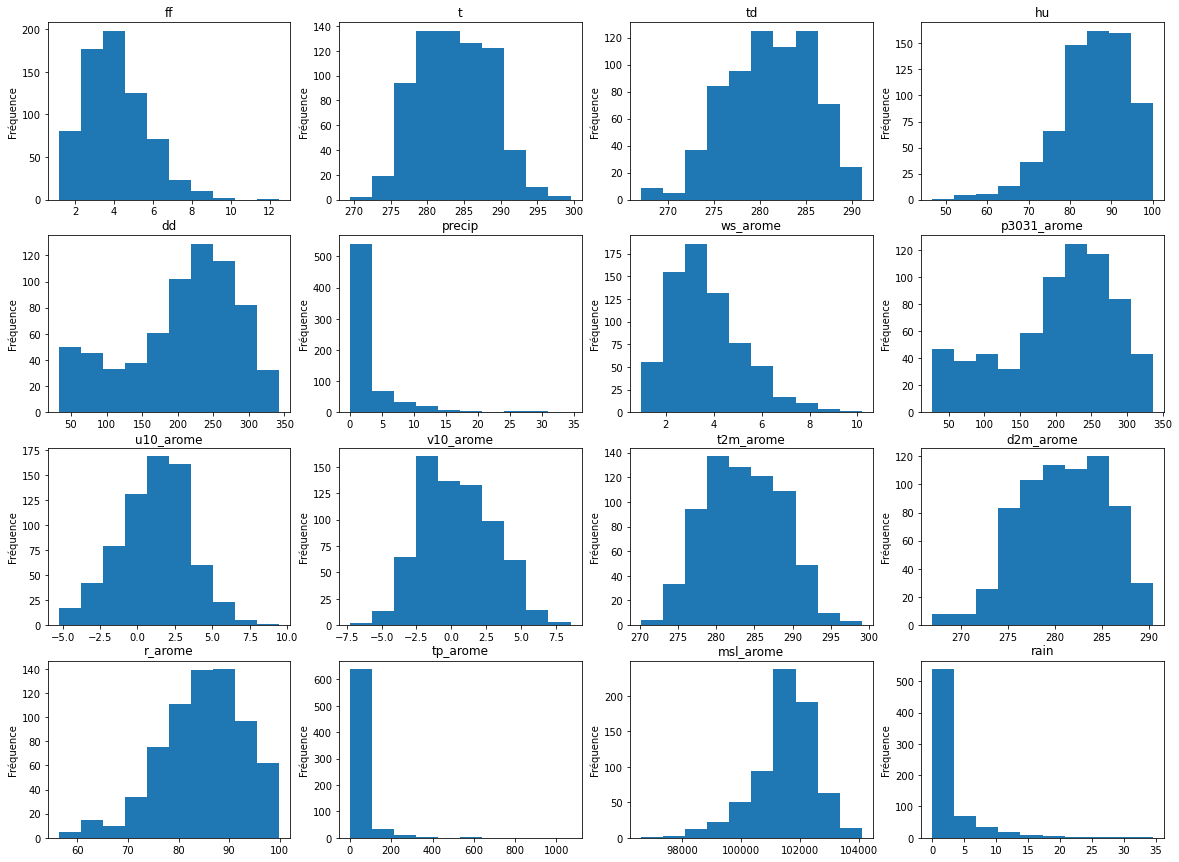

In [255]:
fig = plt.figure(figsize=(20, 15))
p = meteo.columns.size-1
for i in range(1,p):
    plt.subplot(4, 4, i)
    plt.hist(meteo[meteo.columns[i]])
    plt.title(meteo.columns[i])
    plt.ylabel('Fréquence')
plt.show()
plt.close()

**Exercice** Traitement des variables : transformations pour une meilleure utilisation des modèles linéaires. 

In [256]:
app_sqrt = [2,3,5,8,12,13] #liste des variables sur lesquelles on applique sqrt
app_log = [1,7,15] #liste des variables sur lesquelles on applique log
app_tier = [6,11,14,16]
#pas de modif : 9,10
#à refaire : (2),6,14,16
old_names = meteo.columns #stocker les noms pas modifiés
new_names = meteo.columns+"_mod" #nouveaux noms des colonnes modifiées

for i in app_sqrt :
    meteo[new_names[i]]=meteo[old_names[i]].map(lambda x: sqrt(x))
    
for i in app_log :
    meteo[new_names[i]]=meteo[old_names[i]].map(lambda x: log(x))

for i in app_tier :
    meteo[new_names[i]]=meteo[old_names[i]].map(lambda x: x**(1/3))
    
for i in app_sqrt+app_log+app_tier:
    del meteo[old_names[i]]
    
meteo.columns

Index(['date', 'hu', 'u10_arome', 'v10_arome', 'rain_class', 't_mod', 'td_mod',
       'dd_mod', 'p3031_arome_mod', 'd2m_arome_mod', 'r_arome_mod', 'ff_mod',
       'ws_arome_mod', 'msl_arome_mod', 'precip_mod', 't2m_arome_mod',
       'tp_arome_mod', 'rain_mod'],
      dtype='object')

**Exercice** Vérifier l'opportunité de ces transformations (histogrammes des nouvelles variables).

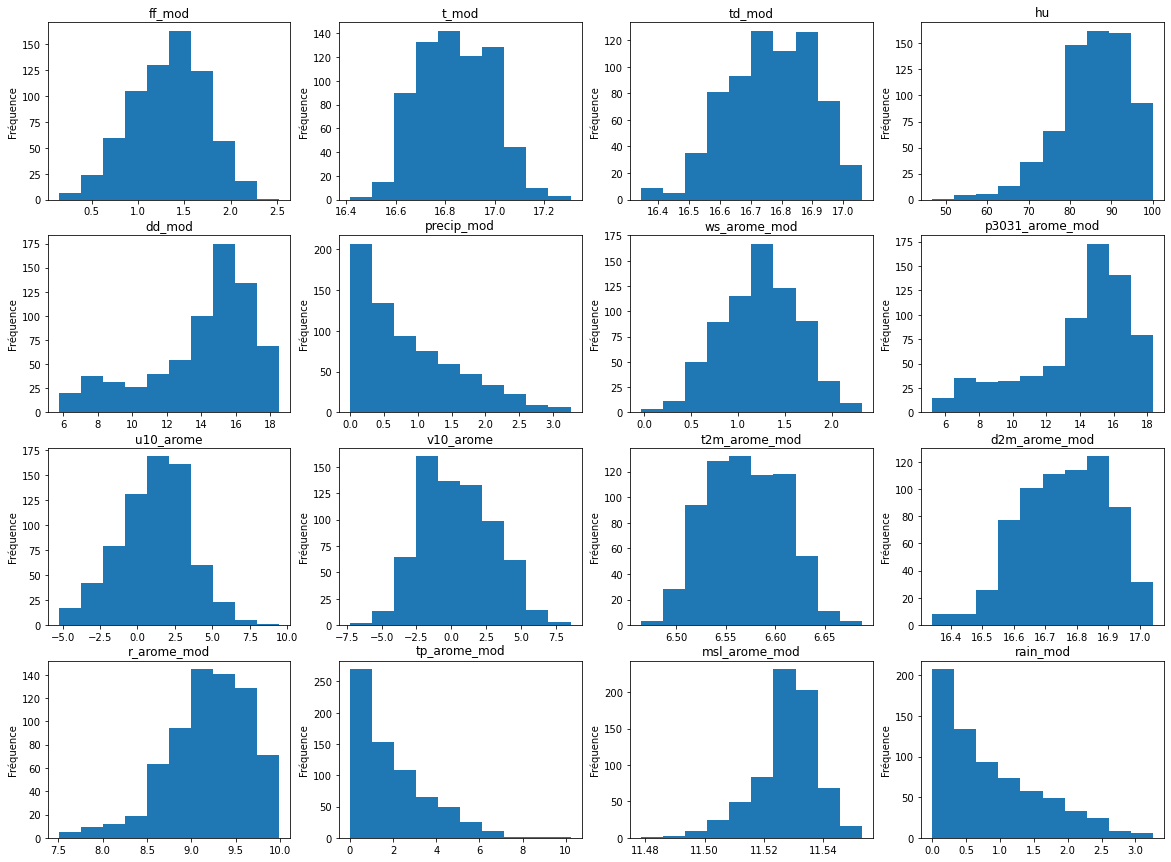

In [257]:
#remettre les variables dans l'ordre pour comparer les affichages facilement
ordre = ["date","ff_mod","t_mod","td_mod","hu","dd_mod","precip_mod","ws_arome_mod","p3031_arome_mod",
        "u10_arome","v10_arome","t2m_arome_mod","d2m_arome_mod","r_arome_mod",
        "tp_arome_mod","msl_arome_mod","rain_mod", "rain_class"]
meteo = meteo[ordre] 

fig = plt.figure(figsize=(20, 15))
p = meteo.columns.size-1
for i in range(1,p):
    plt.subplot(4, 4, i)
    plt.hist(meteo[meteo.columns[i]])
    plt.title(meteo.columns[i])
    plt.ylabel('Fréquence')
plt.show()
plt.close()

### Analyse unidimensionelle des variables d'entrée :

Au vu des graphiques précédents, on établi une analyse unidimensionnelle pour chacune des variables. 

**Les variables relatives à la vitesse du vent :**

- **ff** : vitesse du vent le jour J (en $m.s^{-1}$) : la vitesse du vent ressemble à une distribution gaussienne, environ 175 individus ont une valeur de ff autour de la moyenne qui est de $4 m.s^{-1}$. L’étendue et l’écart interquartiles sont assez faible. On observe quelques outliers dans les valeurs hautes. La force du vent est donc en générale assez constante et basse sauf pour quelques dates où elle est plus importante. 

- **ws_arome** : vitesse du vent prédite pour le lendemain (en $m.s^{-1}$) : Globalement on peut faire les mêmes observations que sur *ff*, à la différence que ws_arome prend des valeurs un peu plus basses en terme de moyenne mais aussi de valeurs extrêmes (son maximum est par exemple de $10 m.s^{-1}$ contre $12 m.s^{-1}$ pour *ff*). On peut se poser la question de si le modèle AROME a tendence à sous-estimer la force du vent mais dans l'ensemble la prédiction semble correcte. 

**Les variables relatives aux précipitations :**
- **precip** : quantité totale des précipitations le jour J ($kg.m^{−2}$) : En moyenne les précipitations sont très faibles, la médiane des observations est à $0.4 kg.m^{−2}$. La distribution a une forme exponentielle. Elle est fortement impactée par des valeurs extrêmes, il y a un nombre important d'outliers et le maximum de précipitations est de  $34.5 kg.m^{−2}$

- **tp_arome**: quantité totale de précipitations prédite pour le lendemain($kg.m^{−2}$) : En comparaison avec *precip*, l'étendue et l'écart interquartile sont plus ressérés. Il y a également beacoup d'outliers et on observe des valeurs extrêmes (maximum à $1069 kg.m^{−2}$ qui semblent aberrantes. Le modèle AROME semble avoir du mal à fournir des prédictions correctes en cas de fortes précipitations. 

**Les variables relatives à la température et au point de rosée :**
- **t** et **t2m_arome** :température le jour J et prédite pour le jour suivant (en Kelvin K): Ces deux variables ont une distribution très similaire, qui ressemble à une gaussienne, sans valeurs extrêmes avec une moyenne de 283 K. Dans l'ensemble la donnée de température ne varie donc pas beaucoup. 

- **td** et **d2m_arome** : point de rosée le jour J et prédite pour le jour suivant (en K) : Mêmes observations que pour *t* et *t2m_arome*

**Les variables relatives à la direction du vent :**
- **dd** et **p3031_arome**: direction du vent le jour J et prédite pour le jour suivant(en degrés) : Ces deux variables ont une distribution très similaire qui ressemble à une gaussienne avec une moyenne (218 degrés) et une médiane (203 degrés) décalées vers les valeurs hautes. L'étendue est très importante et il n'y a pas d'outlier. La direction du vent change beaucoup d'un jour sur l'autre mais le modèle AROME en fournit quand même une bonne prédiction.


- **u10_arome** et **vu10_arome**: composantes U du vent (d'Ouest en Est) et V (du Sud au Nord), prise à 10m de hauteur et prédites pour le jour suivant (en $m.s^{-1}$): Sur ces deux variables la distribution ressemble à une gaussienne, l'étendue est faible. Les composantes U et V restent relativement constantes. 

**Les variables relatives à l'humidité :**
- **hu** et **r_arome** : humidité le jour J et prédite pour le jour suivant (en %) : La distribution a une forme de gaussienne avec la moyenne (de 85%) décalée vers les grandes valeurs et une queue assez importante qui s'étend sur les faibles valeurs (minimum à 50%). L'étendue est importante, on a donc une forte variation de l'humidité au cours de l'année. La prédiction fournit par AROME semble très correcte. 

**La variable relative à la pression atmosphérique :**

- **msl_arome**: pression atmosphérique (en Pa) : La distribution a une forme de gaussienne très bien centrées. Il y a beaucoup d'outlier sur les valeurs basses, ces valeurs sont aberrantes au vu de la régularité du reste de la distribution.

### Analyse unidimensionelle des variables de sortie :
- **rain** : quantité totale de précipitation le jour suivant $kg.m^{−2}$ : La distribution ressemble a une forme d'exponentielle décroissante. La médiane (de $0.4 kg.m^{−2}$) et la moyenne (de $2.3 kg.m^{−2}$ sont très basses et l'étendue est très faible. Mais on observe un très grand nombre d'outlier. On peut remettre en question l'efficacité du modèle AROME pour prédire la variable rain_mod lorsque la quantité de plus est importante. 

- **rain_class**: catégorie de précipitations : no_rain (si rain=0), low_rain (si 0<rain<2), high_rain (si rain>2). Chaque modalité représente environ un tier des observations. Au cours de l'année on a donc à peu près à parts égales des pluies fortes, moyennes et nulles. 

## 3. Exploration multidimensionnelle

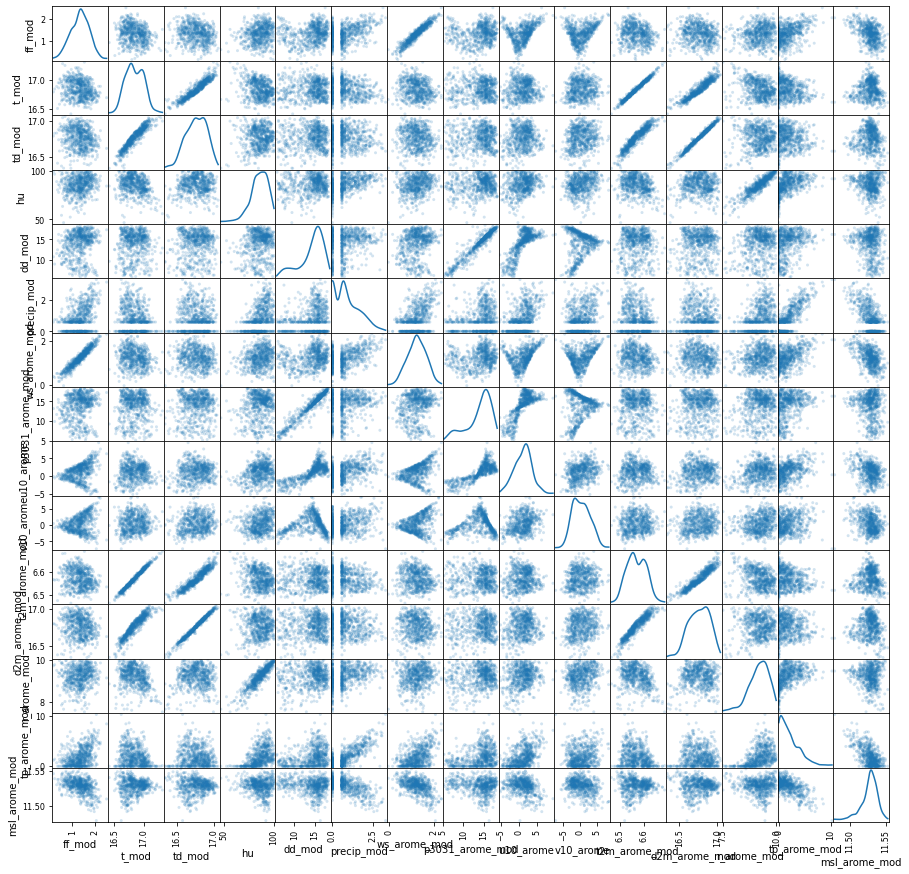

In [258]:
# scatter plot matrix des variables quantitatives
#from pandas.plotting import scatter_matrix
scatter_matrix(meteo[ordre[1:p-1]], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

**Q** Commenter les relations entre les variables prises 2 à 2.

<FONT COLOR="Blue">
La température prédite et la température actuelle sont très corrélées positivement, ainsi que la température et le point de rosée. les variables très corrélées sont ainsi les températures entre elles, le vent actuel et prédit, les points de rosée, le point de rosée et la température. 
Cela est cohérent car la température du jour suivant dépend généralement beaucoup de la température du jour présent.
</font>    

/home/julie/anaconda3/lib/python3.8/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(D, method=method, metric=metric)


<AxesSubplot:>

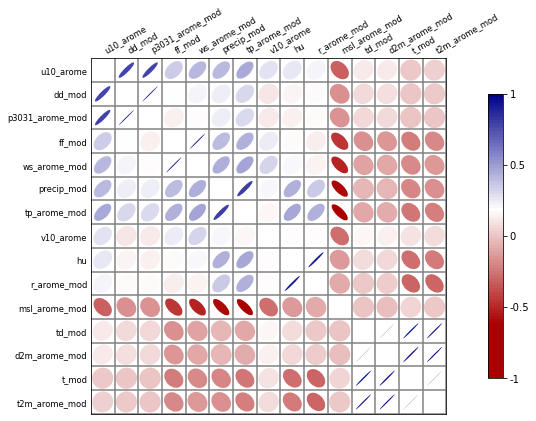

In [259]:
#import pyensae
#from pyensae.graphhelper import Corrplot
c = Corrplot(meteo[ordre[1:p-1]])
c.plot(figsize=(12,6))
## je ne sais pas pourquoi les variables ne sont pas affichées dans l'ordre que j'ai donné

<Figure size 1152x1152 with 0 Axes>

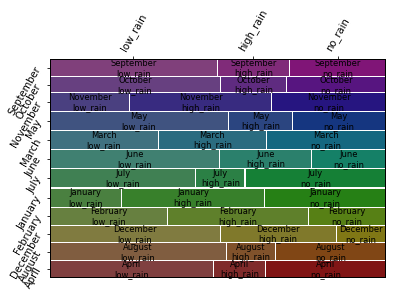

In [260]:
from statsmodels.graphics.mosaicplot import mosaic
crosstable=pd.crosstab(meteo['date'],meteo['rain_class'])

plt.figure(figsize=(16,16))

Fig, _=mosaic(meteo,['date','rain_class'], ax=None, horizontal=False, label_rotation=60)


## 4. Analyse en Composantes Principales

In [261]:
## Avant de réaliser on supprime la variable à expliquer : rain_mod
ordre1 = np.delete(ordre,ordre.index("rain_mod"))
X=scale(meteo[ordre1[1:-1]])
#réduit et centre les données 
print(np.shape(X))

#Pourquoi faire une ACP centrée réduite ? 
#On choisit de faire une ACP réduite, car ici les données n'ont pas la même unité et sont d'ordre de grandeur très différent

(688, 15)


Tous les résultats numétriques classiques sont fournis par l'[implémentation](http://scikit-learn.org/stable/modules/decomposition.html) de scikit-learn mais des  efforts sont à produire pour construire les graphiques usuels généralement automatiquement produits par des librairies dédiées comme [FactoMineR](http://factominer.free.fr/) de R.

Les commandes suivantes permettent de réaliser une analyse en composantes principales sur les seules variables quantitatives. Par ailleurs la variable à modéliser n'est pas utilisée.

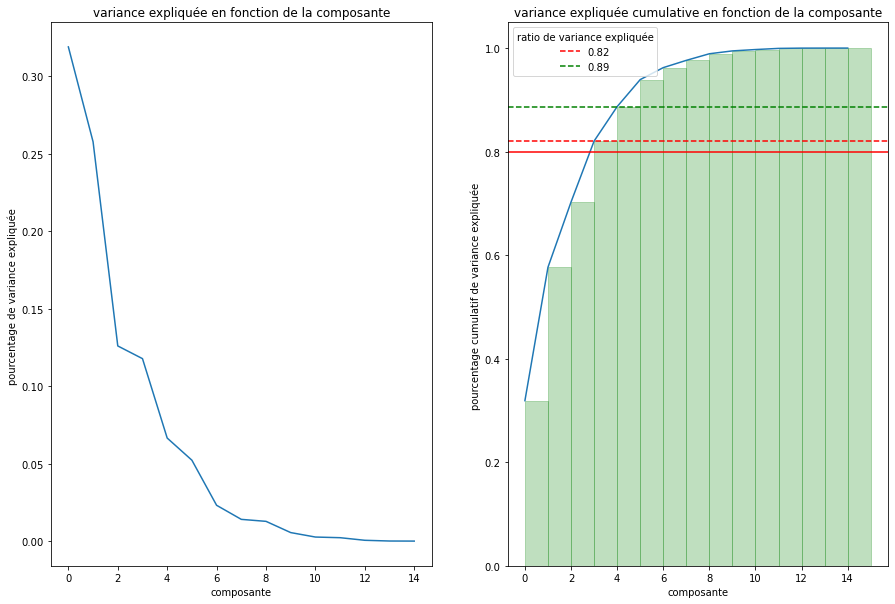

valeurs propres :  [57.37258951 51.57085892 36.05447895 34.86183022 26.20029701 23.21411463
 15.44855511 12.03686463 11.4741051   7.53723064  5.20577485  4.77235054
  2.3430721   0.81963416  0.40377733]


In [262]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)


## Décroissance de la variance expliquée
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.title("variance expliquée en fonction de la composante")
plt.xlabel("composante")
plt.ylabel("pourcentage de variance expliquée ")

plt.subplot(1,2,2)
var_cum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_cum)

x=np.arange(0,len(var_cum))+0.5*np.ones(len(var_cum))
plt.bar(x, var_cum, 1, color='g', edgecolor="g", alpha=0.25)

plt.axhline(y=0.8, c='r')
plt.axhline(y=var_cum[3], color='r', linestyle='--',label=round(var_cum[3],2))
plt.axhline(y=var_cum[4], color='g', linestyle='--',label=round(var_cum[4],2))

plt.title("variance expliquée cumulative en fonction de la composante")
plt.xlabel("composante")
plt.ylabel("pourcentage cumulatif de variance expliquée ")
plt.legend(title="ratio de variance expliquée")
plt.show()
plt.close()

#vecteur des valeurs propres 
print("valeurs propres : ",pca.singular_values_)
#print((pca.singular_values_[:-1]-(+pca.singular_values_[1:]))/pca.singular_values_[:-1])
#idée ; on peut aussi regarder la décroissances des vps. 

<font color="blue"> **Analyse :** 
L'analyse des graphiques suggère de garder les 4 premières composantes de l'ACP pour réduire la dimension sans perdre une quantité trop imporante d'information. 
En effet, sur le graphique des pourcentages cumulées d'intertie, on voit qu'avec 4 composantes on explique 83% de l'inertie. 
On peut aussi observer sur les boxplots que la variance est beaucoup plus importante sur les 4 premiers boxplots que sur les suivants. 

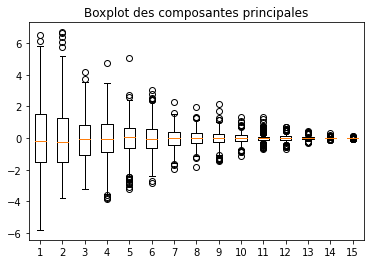

liste des outliers :  [256, 649, 394, 141, 528, 657, 661, 279, 281, 550, 298, 48, 569, 187, 450, 327, 332, 77, 588, 592, 337, 594, 211, 597, 96, 224, 355, 240, 498]


In [263]:
## distribution des composantes principales
plt.figure()
plt.boxplot(C[:,:])
plt.title("Boxplot des composantes principales")
plt.show()
plt.close()


nb_compo_conservees=5

############TROUVER LES VALEURS ABERRANTES (renvoie les indices de la colonne de C) ######
def outlier(n):#n est le numéro de la colonne de C 
    Q1 = np.percentile(C[:,n], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(C[:,n], 75,
                   interpolation = 'midpoint')
    
    upper = C[:,n] >= (Q3+1.5*(Q3-Q1))
    lower = C[:,n] <= (Q1-1.5*(Q3-Q1))
    #print("indices des outliers au dessus :", np.where(upper), "indices des outliers en dessous", np.where(lower))
    return np.where(lower), np.where(upper)

#construction de la liste des outliers 
#lower, upper=outlier(0)
#print(lower)
#print(upper)
x=[]
for n in range (0,nb_compo_conservees): 
    lower, upper=outlier(n)
    x=x+list(lower[0])+list(upper[0])

y=list(set(x)) #passer au set permet de supprimer les doublons

C_sans_outlier=np.delete(C, y, 0) #supprime les outliers
X_sans_outlier=np.delete(X, y, 0)
print("liste des outliers : ",y)

**Q** Commenter ces résultats: quel choix de la dimension? 
On observe ici les valeurs prises par les individus quand ils sont projetés sur les différentes composantes, on voit que 
**Q** Présence de valeurs atypiques.

<FONT COLOR="blue"> **Pourcentage cumulé de variance expliquée** : Plus l'inertie d'une composante principale est grande (valeur propre importante), mieux elle conserve des données, c'est à dire que l'information est bien conservée par projection sur l'axe. Pour déterminer le nombre de composantes principales à garder, on s’intéresse donc à l’inertie de chacune de ces composants. Pour avoir 80% de l’inertie globale, il faut garder au moins les quatre premières composantes : elles cumulent à elles seules 82% de l’inertie globale

**Boxplot** : Le boxplot nous permet d'observer la distribution des projections. Avec le boxplot on voit que l'ensemble des projections sont bien sur les dimensions 1, 2,3,4 : on remarque que ces premières composantes contiennent presque toute la variance. Cela nous fait alors considérer les 4 premières composantes.
    
**Eboulis** : Sur le graphique présentant la décroissance des valeurs propres on remarque un coude au niveau de la composante. On doit garder toutes les composantes qui précèdent ce coude. On garde ici 4 composantes
    
<FONT COLOR="blue"> Les composantes sont relativement symétriques, mais on constate que pour les composantes il y a entre 1 et 8 outliers. Ce sont des valeurs atypiques qui peuvent biaiser les résultats fournis par l'ACP, car la matrice de covariance est sensible aux outliers.La variance de ces composantes peut etre surestimée. Il faudra donc tester sans les valeurs des outliers pour vérifier la validité de notre ACP. 

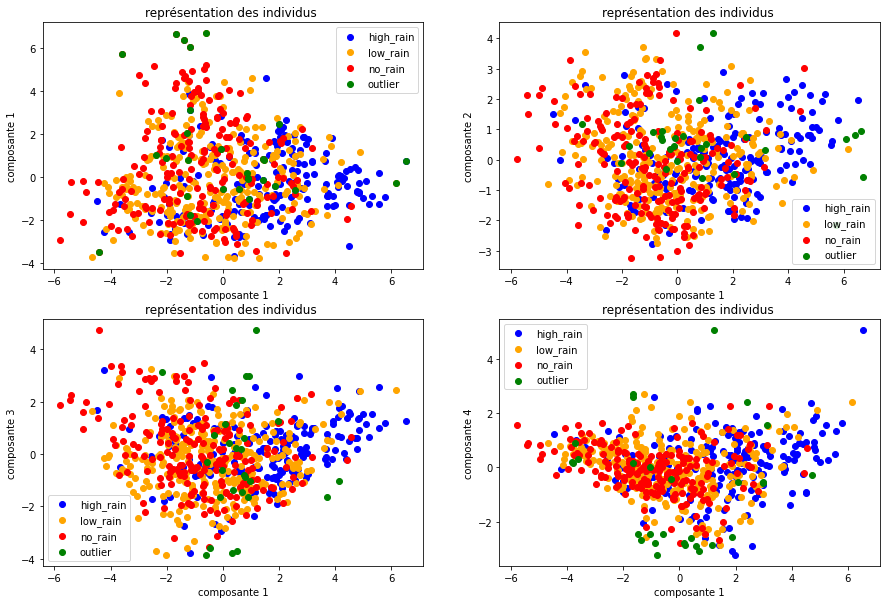

In [264]:
## Représentation des individus
highrain=np.where(meteo['rain_class']=="high_rain")
lowrain=np.where(meteo['rain_class']=="low_rain")
norain=np.where(meteo['rain_class']=="no_rain")

plt.figure(figsize=(15, 10))

pos=0
for i in range(0,4):
    pos+=1
    plt.subplot(2,2,pos)
    plt.scatter(C[highrain,0], C[highrain,i+1], c="b", label="high_rain")
    plt.scatter(C[lowrain,0], C[lowrain,i+1], c="orange", label="low_rain")
    plt.scatter(C[norain,0], C[norain,i+1], c="r", label="no_rain")
    plt.scatter(C[y,i], C[y,i+1], c="g", label="outlier")
    plt.title("représentation des individus ")
    plt.xlabel("composante 1")
    plt.ylabel("composante {}".format(i+1))
    plt.legend()

**analyse du graphe des individus** : 
- On a du mal à distinguer une séparation entre les modalités *high_rain*, *low_rain* et *no rain*. Il semblerait que les individus les plus à droite sur la dimension 1 portent la modalité *high_rain*, mais les deux autres modalités sont assez mélangées comme on eput le voir sur le dernier graphe où leurs ellipses se superposent. 
- Remarque sur les outliers : Les outliers 354,348 et 636 ont de très faibles valeurs de précipitations (precip_mod et tp_arome_mod), leurs valeurs sur ces variables correspondent au minimum. Cela s'observe aussi sur le premier graphique pour lequel les points les plus en bas autour de l'axe de la dimension 2 portent tous la mention "no rain". 

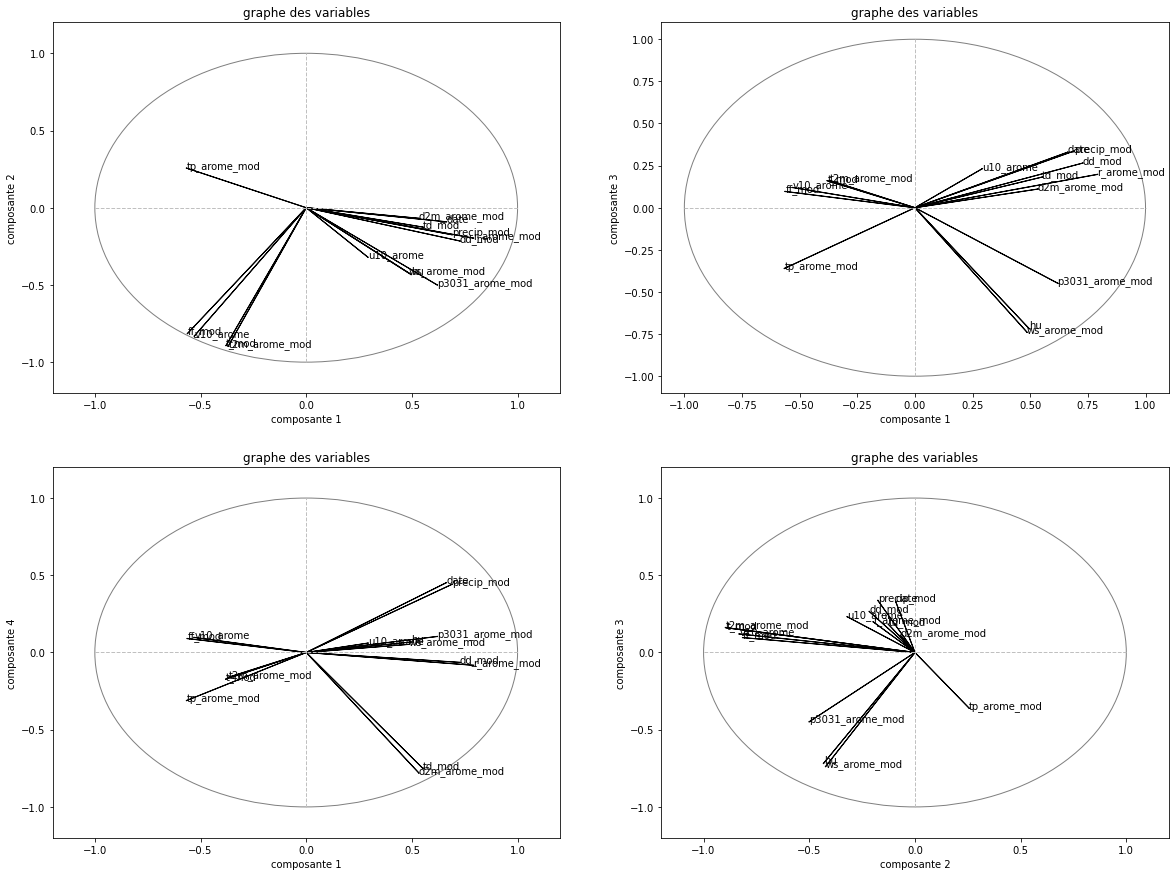

In [265]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
coord3=pca.components_[2]*np.sqrt(pca.explained_variance_[2])
coord4=pca.components_[3]*np.sqrt(pca.explained_variance_[3])

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(2, 2, 1)
for i, j, nom in zip(coord1,coord2, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
e=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
plt.xlabel("composante 1")
plt.ylabel("composante 2")
plt.title("graphe des variables")
ax.add_patch(e)

ax2 = fig.add_subplot(2, 2, 2)
for i, j, nom in zip(coord1,coord3, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
plt.xlabel("composante 1")
plt.ylabel("composante 3")
plt.title("graphe des variables")
ax2.add_patch(c)


ax3= fig.add_subplot(2, 2,3)
for i, j, nom in zip(coord1,coord4, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
    plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
d=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
ax3.add_patch(d)
plt.xlabel("composante 1")
plt.ylabel("composante 4")
plt.title("graphe des variables")

ax4= fig.add_subplot(2, 2,4)
for i, j, nom in zip(coord2,coord3, meteo[ordre1].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
    plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
d=plt.Circle((0,0), radius=1, color='gray', fill=False)
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)
ax4.add_patch(d)
plt.xlabel("composante 2")
plt.ylabel("composante 3")
plt.title("graphe des variables")

plt.axis((-1.2,1.2,-1.2,1.2))
plt.show()

**Analyse :** 
Le graphe PCA des individus permet d'observer les mêmes corrélations entre les variables que sur le corrplot. 

Variables bien projetées sur la **dimension 1** : 
- Les variables relatives à la vitesse du vent (ff_mod, ws_arome_mod) 
- les variables relatives aux précipitations (precip_mod et tp_arome)

Variables bien projetées sur la **dimension 2** :
- Les variables relatives à la température et au point de rosée (t_mod, td_mod, t2m_arome_mod et d2m_arome_mod)

Variables bien projetées sur la **dimension 3** :
- Les variables relatives à la direction du vent (dd_mod, p3031_arome_mod, u10_arome)

Variables bien projetées sur la **dimension 4** :
- Les variables relatives à l'humidité (hu et r_arome)

**Q** Commenter la structure de corrélation des variables.

<FONT COLOR="Blue"> Quand on regarde la composante 1 contre les autres composantes on arrive globalement sur chacune des représentations ci-dessus à distinguer 4 à 6 groupes de variables corrélées. Cela suggère qu'on aura besoin de garder 4 à 6 composantes principales dans l'ACP, c'est-à-dire qu'on va pouvoir réduire la dimension. </font>

**Q** L'objectif est de définir une surface séparant les deux classes. Une discriminaiton linéaire (hyperplan) semble-t-elle possible?  

<FONT COLOR="Blue"> Comme on peut le voir dans le clustering suivant, il est possible de définir une surface séparant des classes lorsque l'on compare la composante 1 qui porte le plus d'information aux autres composantes. </font>

### Clustering (K-Means)

In [266]:
#from sklearn.cluster  import  KMeans
#from  sklearn.metrics  import confusion_matrix
clust=KMeans(n_clusters=4)
clust.fit(X)
classe=clust.labels_


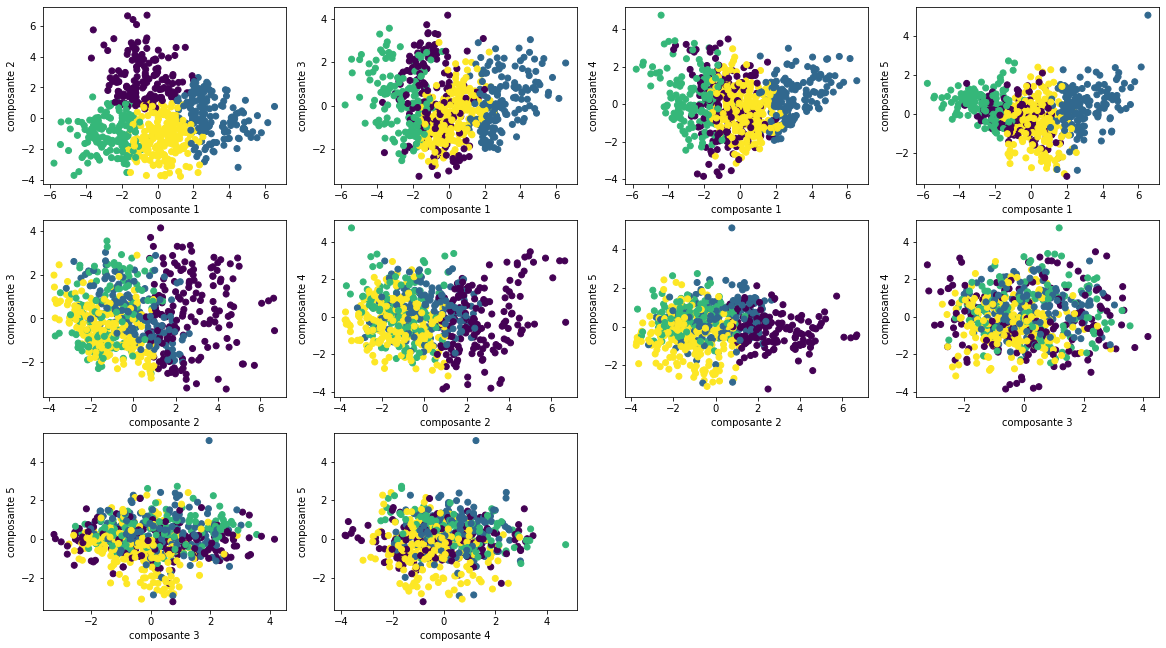

In [267]:
## Repésentation des individus dans les coordonnées de l'acp.
pos = 0
fig = plt.figure(figsize=(20, 15))
for i in range(0,nb_compo_conservees):
    for j in range(i+1,nb_compo_conservees):
        pos += 1
        plt.subplot(4, 4, pos)
        plt.scatter(C[:,i], C[:,j], c=classe)
        plt.xlabel("composante {}".format(i+1))
        plt.ylabel("composante {}".format(j+1))
plt.show()


###  LDA ("ACP supervisée")

Text(0.5, 1.0, 'LDA rain_class')

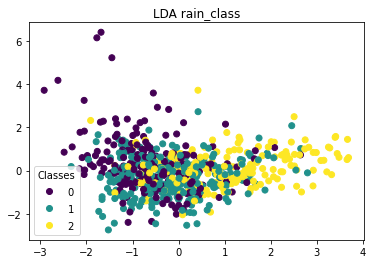

In [268]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_r2 = lda.fit(X, list(meteo["rain_class"])).transform(X)

meteo_rain_num=np.copy(list(meteo['rain_class']))
meteo_rain_num[np.where(meteo['rain_class']=="high_rain")]=2
meteo_rain_num[np.where(meteo['rain_class']=="low_rain")]=1
meteo_rain_num[np.where(meteo['rain_class']=="no_rain")]=0
fig, ax = plt.subplots()

# Because the price is much too small when being provided as size for ``s``,
# we normalize it to some useful point sizes, s=0.3*(price*3)**2
scatter = ax.scatter(X_r2[:,0], X_r2[:,1], c=meteo_rain_num.astype(int))

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

plt.title("LDA rain_class")

In [269]:
print(lda.coef_)
print(lda.classes_)

tmp= pd.DataFrame(lda.coef_.transpose(),columns=lda.classes_)
print(tmp)

[[ 0.18202841 -1.14480277  0.20771721 -0.08476215 -0.05311863  0.44005696
  -0.32433346  0.07219359  0.45777183  0.27876859  2.81483508 -2.173947
   0.81661806 -0.41394658 -0.80896989]
 [ 0.01434861 -3.99108032  2.74681685 -1.14641748  0.186732    0.05710393
  -0.07002423 -0.29436716 -0.01635478 -0.01376431  4.33459404 -2.83481446
   1.21922674  0.06559876  0.33032871]
 [-0.18466892  6.63758835 -4.04385267  1.68600572 -0.21413193 -0.47790891
   0.39145079  0.34799431 -0.39079571 -0.23264095 -8.62928103  5.94455701
  -2.44970385  0.28205346  0.26745364]]
['high_rain' 'low_rain' 'no_rain']
    high_rain  low_rain   no_rain
0    0.182028  0.014349 -0.184669
1   -1.144803 -3.991080  6.637588
2    0.207717  2.746817 -4.043853
3   -0.084762 -1.146417  1.686006
4   -0.053119  0.186732 -0.214132
5    0.440057  0.057104 -0.477909
6   -0.324333 -0.070024  0.391451
7    0.072194 -0.294367  0.347994
8    0.457772 -0.016355 -0.390796
9    0.278769 -0.013764 -0.232641
10   2.814835  4.334594 -8.6292

In [270]:

# variable à expliquer multinomiale
Yb=meteo["rain_class"]
# variable à expliquer réelle
Yr=meteo["rain_mod"]
meteoDum=pd.get_dummies(meteo[["date"]])
meteoQuant=meteo[["ff_mod","t_mod","td_mod","hu","dd_mod","precip_mod","ws_arome_mod","p3031_arome_mod","u10_arome","v10_arome","t2m_arome_mod","d2m_arome_mod","r_arome_mod","tp_arome_mod","msl_arome_mod"]]
mat=pd.concat([meteoDum,meteoQuant],axis=1)
X_train,X_test,Yb_train,Yb_test=train_test_split(mat,Yb,test_size=0.2,random_state=11)

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, Yb_train)

# without cross-valdidation
prediction = clf.predict(X_test)

table=pd.crosstab(prediction, Yb_test, dropna=False)
table

rain_class,high_rain,low_rain,no_rain
row_0,,,
high_rain,18,9,4
low_rain,14,35,21
no_rain,3,12,22


In [271]:
purity(table)

0.5434782608695652

In [272]:
print(np.diag(table)/np.sum(table,axis=0))

rain_class
high_rain    0.514286
low_rain     0.625000
no_rain      0.468085
dtype: float64


<FONT COLOR="Blue"> On fait une cross tab pour faire l'erreur de généralisation obtenue sur l'échantillon test, on voit que cette matrice est presque symétrique. On voit que le taux de réussite n'est pas très bon pour chaque classe 

<FONT COLOR="Blue"> La LDA est une méthode qui tient compte de class_rain pour faire l'ACP. La LDA est donc une sorte d'acp SUPERVISEE. Elle suppose deux hypythèses vérifiées : 
que la structure de variance soit identique pour toutes les classes et qu'elles sont gaussienne.Ici on voit que les nuages ne sont pas forcément sphériques, car les variances ne sont pas forcément identiques dans les différentes activités. On voit qu'elle n'est pas vraiment discriminante, que les classes low rain et no rain sont presque confondues. Seule la classe high rain est légèrement plus discriminée, mais cela reste encore relatif.

## Modélisations

La recherche  d'une meilleure méthode de prévision suit généralement le protocole suivant dont la première étape est déja réalisée.


1. Etape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf).
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test ([validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)), afin de réduire la variance (moyenne) des estimations des erreurs de prévision.
* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test !
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...
* L'étape "choix" de la meilleure méthode peut être remplacée par une combinaisons de prévision comme c'est souvent le cas dans les soutions "gagnantes" mais lourdes du site [kaggle](https://www.kaggle.com/competitions).

### Extraction des échantillons apprentissage et test

Transformation des données pour l'apprentissage. 

<FONT COLOR="Blue">On transforme la variable qualitatitve **date** en variable quantitative en utilisant des indicatrices. La première modalité **date_January** est automatiquement supprimée (ce qui revient à la mettre dans l'intercept) pour garder un modèle régulier. 

In [273]:
meteo.head()

,date,ff_mod,t_mod,td_mod,hu,dd_mod,precip_mod,ws_arome_mod,p3031_arome_mod,u10_arome,v10_arome,t2m_arome_mod,d2m_arome_mod,r_arome_mod,tp_arome_mod,msl_arome_mod,rain_mod,rain_class
1,June,1.372449,17.012018,16.890148,78.783333,15.708278,0.000000,1.298497,15.630083,3.038503,1.416360,6.613260,16.887003,8.890320,1.325394,11.529516,0.584804,low_rain
2,March,1.318974,16.624555,16.535492,81.700000,16.134848,1.062659,1.202515,17.483156,2.463886,-1.898971,6.509325,16.543053,9.291480,2.201888,11.518746,1.613429,high_rain
3,July,1.185936,16.996152,16.932907,87.620833,16.094771,0.584804,1.173219,16.001325,2.963872,0.985627,6.616270,16.925872,9.071992,1.660969,11.527646,0.000000,no_rain
4,May,0.556755,16.860864,16.739649,76.587500,14.715355,0.000000,0.542862,11.802426,-0.260693,-1.397603,6.578736,16.744173,8.682403,0.979674,11.534918,0.000000,no_rain
5,February,1.743750,16.659169,16.568922,81.391667,16.897978,1.169607,1.487047,16.899077,3.940056,-1.457606,6.524575,16.570777,8.968561,2.404567,11.536800,0.000000,no_rain


In [274]:
# Variables explicatives
meteoDum=pd.get_dummies(meteo[["date"]])
meteoQuant=meteo[["ff_mod","t_mod","td_mod","hu","dd_mod","precip_mod","ws_arome_mod","p3031_arome_mod","u10_arome","v10_arome","t2m_arome_mod","d2m_arome_mod","r_arome_mod","tp_arome_mod","msl_arome_mod"]]
dfC=pd.concat([meteoDum,meteoQuant],axis=1)
dfCsansmodalite=pd.concat([meteo["date"],meteoQuant],axis=1)
dfCsansmodalite.head()
#dfC.head()

,date,ff_mod,t_mod,td_mod,hu,dd_mod,precip_mod,ws_arome_mod,p3031_arome_mod,u10_arome,v10_arome,t2m_arome_mod,d2m_arome_mod,r_arome_mod,tp_arome_mod,msl_arome_mod
1,June,1.372449,17.012018,16.890148,78.783333,15.708278,0.000000,1.298497,15.630083,3.038503,1.416360,6.613260,16.887003,8.890320,1.325394,11.529516
2,March,1.318974,16.624555,16.535492,81.700000,16.134848,1.062659,1.202515,17.483156,2.463886,-1.898971,6.509325,16.543053,9.291480,2.201888,11.518746
3,July,1.185936,16.996152,16.932907,87.620833,16.094771,0.584804,1.173219,16.001325,2.963872,0.985627,6.616270,16.925872,9.071992,1.660969,11.527646
4,May,0.556755,16.860864,16.739649,76.587500,14.715355,0.000000,0.542862,11.802426,-0.260693,-1.397603,6.578736,16.744173,8.682403,0.979674,11.534918
5,February,1.743750,16.659169,16.568922,81.391667,16.897978,1.169607,1.487047,16.899077,3.940056,-1.457606,6.524575,16.570777,8.968561,2.404567,11.536800


<FONT COLOR="Blue"> Les variables explicatives de notre modèle $X= (X^1,..,X^p)$ sont les « paramètres météorologiques observés le jour j» et les « prévisions météos du jour suivant par le modèle arome». </font>

 <FONT COLOR="Blue"> Les variables à expliquer $Y$ sont : **rain_class** pour la classification ($Y \in \left\{ 1..K
\right\} $) et **rain** pour la regression ($Y \in \mathbb{R}$). </font>

Extractions des échantillons d'apprentissage  et test pour les deux types de modèles. Comme le générateur est initalisé de façon identique, ce sont les mêmes échantillons dans les deux cas.

In [275]:
# variable à expliquer multinomiale
Yb=meteo["rain_class"]
# variable à expliquer réelle
Yr=meteo["rain_mod"]

In [276]:
# construction de l'échantillon d'apprentissage :
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=0.2,random_state=11)#on sélectionne rain_class pour la classification
X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=0.2,random_state=11)#on sélectionne rain_mod pour la régression

In [277]:
X_train2,X_test2,Yb_train2,Yb_test2=train_test_split(dfCsansmodalite,Yb,test_size=0.2,random_state=11)#on sélectionne rain_class pour la classification
X_train2,X_test2,Yr_train2,Yr_test2=train_test_split(dfCsansmodalite,Yr,test_size=0.2,random_state=11)#on sélectionne rain_mod pour la régression

L'étape suivante est une étape de standardisation des données ou normalisation. Les variables sont divisées par leur écart-type. Ce n'est pas utile dans le cas d'un modèle linéaire élémentaire car la solution est identique mais indispensbale pour beaucoup d'autres méthodes non linéaires (SVM, réseaux de neurones, modèles avec pénalisation). Cette étape est donc concrètement systématiquement exécutée pour éviter des soucis. *Attention*, les mêmes paramètres  (moyennes, écarts-types) estimés sur l'échantillon d'apprentissage sont utilisés pour normaliser l'échantillon test. 

In [278]:
# L'algorithme ds réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
Xr_test = scaler.transform(X_test)

### Modèles linéaires

Les fonctions de modéles linéaires et linéaires généralisées sont limitées dans [Scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) et sans sorties numériques (tests) détaillées qui sont à rechercher dans une autre librairie ([StatsModels](http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/glm.html)). Dans les deux cas, les stratégies classiques (forward, backward, stepwise, Furnival et Wilson) de sélection de variables par optimisation d'un critère (Cp, AIC, BIC) ne semblent pas disponibles, même si AIC et BIC sont présents dans scikit-learn, et le type DataFrame (package *pandas*) n'est pas reconnu.

La façon efficace de procéder est donc d'introduire une [pénalisation Lasso](http://wikistat.fr/pdf/st-m-app-select.pdf) pour opérer une sélection de variables ou plutôt la sélection de variables quantitatives et d'indicatrices des modalités de celles qualitatives mais sans analyse fine des interactions comme cela est possible avec R.

<FONT COLOR = "blue"> Le modèle déterministe est ici donné par le modèle AROME. Nous allons comparer **rain** (devenue **rain_mod** après modification) représentant la quantité totale de précipitation le jour suivant à **tp_arome**  (devenue **tp_arome_mod** après modification) représentant la quantité totale de précipitation le jour suivant d'après le modèle AROME.

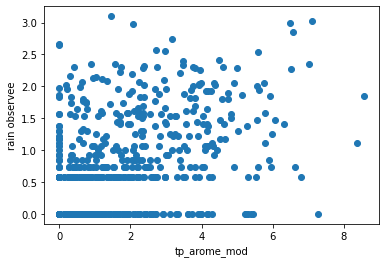

In [279]:
plt.plot(X_train["tp_arome_mod"],Yr_train,"o")
plt.xlabel("tp_arome_mod")
plt.ylabel("rain observee")
plt.show()

In [280]:
#from sklearn.metrics import r2_score
print("R2=",r2_score(Yr_train,X_train["tp_arome_mod"]))

R2= -5.62591088189844


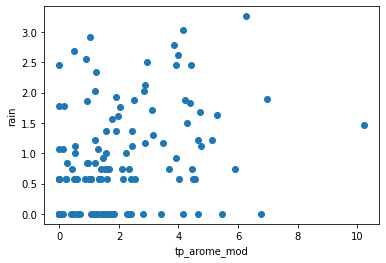

In [281]:
plt.plot(X_test["tp_arome_mod"],Yr_test,"o")
plt.xlabel("tp_arome_mod")
plt.ylabel("rain")
plt.show()

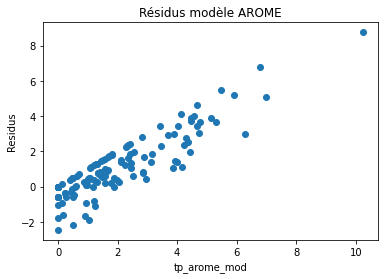

In [282]:
plt.plot(X_test["tp_arome_mod"],X_test["tp_arome_mod"]-Yr_test,"o")
plt.xlabel("tp_arome_mod")
plt.ylabel("Residus")
plt.title("Résidus modèle AROME")
plt.show()

**Q** Commenter la qualité de ces résidus.
- <FONT COLOR="Blue"> Les résidus ne sont pas dispersés de façon équivalente. Cela signifie que la variance dépend de Y et n'est pas constante (hétéroscédasticité). 
- <FONT COLOR="Blue"> On observe une forme particulière (au moins 3 droites parallèles) dans le nuage donc il y a toujours une tendance ce qui suggère que les résidus ne sont pas indépendants entre eux. 
- <FONT COLOR="Blue"> Il y beaucoup d'outliers 

<FONT COLOR="Blue"> Lorsqu'il y a une droite cela signifie que sur plusieurs données on a la même valeur pour la quantité de pluie réelle. En effet les résidus sont obtenus de la manière suivante $\hat \epsilon = Y - \hat Y$ donc si Y est constante, alors on observe une droite. Par exemple, la première droite  $\hat \epsilon =  - \hat Y $ passe par l'origine du repère donc $Y = 0$ c'est à dire qu'il n'y a pas de pluie. En effet, on observe dans les données qu'il y a beaucoup de jours pour lesquels la pluie est nulle.
 

In [283]:
# Erreur quadratique moyenne
print("erreurs pour le modèle AROME")
print("--------------------------")
print("MSE=",mean_squared_error(X_test["tp_arome_mod"],Yr_test))
print("MAPE=", MAPE(list(X_test["tp_arome_mod"]),list(Yr_test)))
# Le coefficient de détermination 
# peut être négatif en prévision avec un mauvais modèle, 
# est nul si la prévision est constante égale à la moyennne
print("R2=",r2_score(Yr_test,X_test["tp_arome_mod"]))

erreurs pour le modèle AROME
--------------------------
MSE= 4.08490949153839
MAPE= 41.82100936842558
R2= -4.885981098305556


#### [Régression linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou modèle gaussien

<FONT COLOR = "blue"> Nous allons comparer cette prévision déterministe par le modèle AROME à l'adaptation statistique la plus élémentaire. Il s'agit d'une régression avec choix de modèle par régularisation avec une pénalisation lasso. 

<FONT COLOR = "blue"> Pour la regression lasso, on ne conserve que les variables quantitatives. On met dans x la variable à expliquer **rain_mod** et dans y toutes les variables sauf la variable qualitative **date**, **class_rain** et la variable à expliquer **rain_mod**. 
    
<FONT COLOR="Blue"> En python la valeur par défaut en python pour le paramètre de pénalisation 𝛼 est 1 (on peut le voir en faisant help(linear_model.Lasso))
    
    
<FONT COLOR="Blue">**Méthode Lasso**
    
<FONT COLOR="Blue">* Objectif d'utilisation de la méthode : 
    
   <FONT COLOR="Blue"> Annuler des coefficients du vecteur θ (vecteurs des paramètres), en faisant une sélection de variables, de manière à rendre notre modèle plus interprétable. 
       
<FONT COLOR="Blue">* Variables à tuner :  
    
<FONT COLOR="Blue">$\lambda$(paramètre d’ajustement/pénalisation) : plus il est faible plus le risque d'overfitting est important, plus il est grand plus un nombre important de variables est annulé. Nous le tunons grâce à la validation croisée. \\
    
    




In [284]:
regLasso = linear_model.Lasso(alpha=0)
regLasso.fit(Xr_train,Yr_train)
prev=regLasso.predict(Xr_test)
print("MSE=",mean_squared_error(Yr_test,prev))
print("MAPE=", MAPE(list(Yr_test), prev)) 

MSE= 0.47596944123805457
MAPE= 33.95162148985955


<ipython-input-284-03477803b2e3>:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regLasso.fit(Xr_train,Yr_train)
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.020e+02, tolerance: 3.052e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [285]:
#from sklearn import linear_model
regLasso = linear_model.Lasso()
regLasso.fit(Xr_train,Yr_train)
prev=regLasso.predict(Xr_test)

In [286]:
print("R2=",r2_score(Yr_test,prev))

R2= -0.0001819324448388837


Le paramètre de pénalisation lasso est optimisé par validation croisée.

In [287]:
# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.01,0.02, 0.025,0.03,0.035, 0.04,0.05,0.1,0.2,0.3,0.4,0.5,1,1.3,1.5,1.6,1.7,1.8,2,4]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(Xr_train, Yr_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))

Meilleur R2 = 0.271601, Meilleur paramètre = {'alpha': 0.03}


**Q** Quelle validation croisée est exécutée? <FONT COLOR="Blue"> Il s'agit d'un 5-fold CV. </font>

Prévision avec la valeur optimale de `alpha` puis calcul et tracé des résidus.

In [288]:
prev=regLassOpt.predict(Xr_test)
print("résultats pour le modèle linéaire LASSO")
print("-----------------------------------------")
print("MSE=",mean_squared_error(prev,Yr_test))

print("MAPE=", MAPE(list(Yr_test), prev))
print("R2=",r2_score(Yr_test,prev))

résultats pour le modèle linéaire LASSO
-----------------------------------------
MSE= 0.47389950506691036
MAPE= 34.09869890341539
R2= 0.31715414133454667


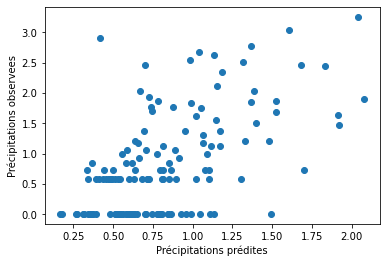

In [289]:
plt.plot(prev,Yr_test,"o")
plt.xlabel(u"Précipitations prédites")
plt.ylabel("Précipitations observees")
plt.show()

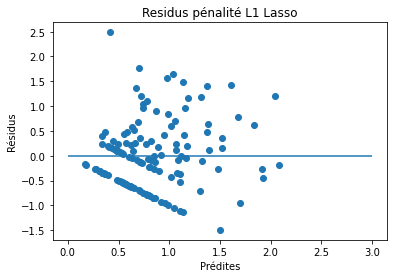

In [290]:
plt.plot(prev,Yr_test-prev,"o")
plt.xlabel(u"Prédites")
plt.ylabel(u"Résidus")
plt.title("Residus pénalité L1 Lasso") 
plt.hlines(0,0,3)
plt.show()

<FONT COLOR="Blue"> **Comparaison avec le modèle AROME :** 
    
- **MSE et R² :** Avec la pénalisation L1 de Lasso, on obtient de meilleurs MSE et R². En effet, un bon modèle doit avoir un MSE faible et un R² proche de 1.      

- **Graphique des résidus :** On remarque un graphe plus ramassé avec la regression lasso (pénalité L1). La dispersion des données sur l'axe des ordonées semble identique tandis que la dispersion sur l'axe des abscisses est moins importante avec la pénalité L1. </font>

L'interprétation nécessite de connaître les valeurs des coefficients du modèle alors que l'objet `regLassOpt` issu de `GridSearchCV` ne retient pas les paramètres estimés. Il faut donc le ré-estimer avec la valeur optimale du paramètre de pénalisation si l'on souhaite afficher ces coefficients.

In [291]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(Xr_train,Yr_train)
model_lasso.coef_

array([-0.        , -0.        ,  0.02264375,  0.01106697,  0.        ,
       -0.01439146, -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.04202933, -0.        ,
        0.        ,  0.        ,  0.12418514, -0.        ,  0.        ,
        0.11845153,  0.07446328, -0.        , -0.        ,  0.        ,
       -0.        , -0.1589435 ])

In [292]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 8 variables et en supprime 19


Text(0.5, 1.0, 'Coefficients du modèle lasso')

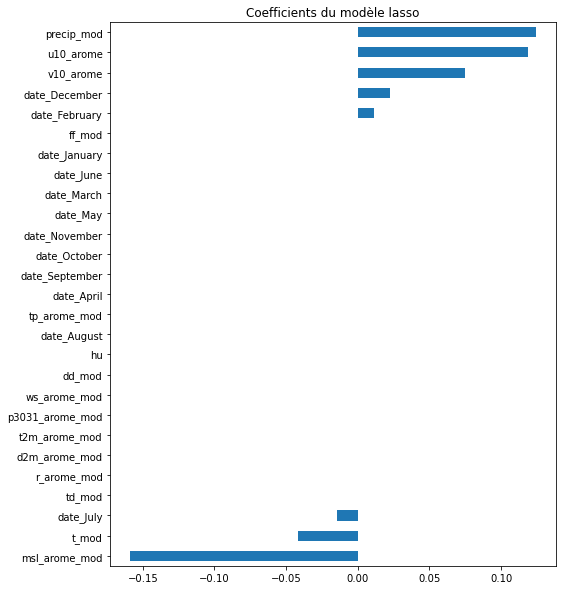

In [293]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

**Q** Noter les conséquences de la pénalisation

<FONT COLOR="Blue"> **Effets de la regression LASSO :** 
<FONT COLOR="Blue">- La pénalisation Lasso a permi de supprimer un grand nombre de variable. Elle garde 10 variables et en supprime 17. En effet, Lasso permet d'obtenir un estimateur parcimonieux pour rendre le modèle plus interprétable. 
<FONT COLOR="Blue">- Les paramètres qui semblent avoir le plus d'influence sur les précipitations sont *precip_mod*, *u10_arome*, *v10_arome* et *msl_arome_mod*. *t_mod*, date_december et *date_February* ont également été sélectionné mais sont d'importance moindre. 
</font> 

<FONT COLOR="Blue">Cela est assez cohérent avec le diagramme de corrélation qu'on avait tracé précédemment, car on avait que *precip* et*tp_arome* étaient très corrélées, et la sélection de variables permet de ne garder que *precip_mod*. De même pour *ws_arome* qui était très corrélée avec *precip_mod*, *tp_arome*, *ff_mod*. On ne garde au final que *ws_mod*.


<FONT COLOR="Blue">C'est ici qu'apparaît une insuffisance de la librairie python. Il faudrait construire "à la main" ou utiliser la librairie *Statsmodels* pour afficher les statistiques des tests et p-valeurs. Même avec ces compléments, la prise en compte des interactions et de leur sélection ne sont pas prévues. De plus l'interprétation est compliquée par l'éclatement de chaque variable qualitative en paquets d'indicatrices. C'est encore compréhensible avec peu de variables mais devient rapidement inexploitable.

*Scikit-learn* propose d'autres procédures d'optimisation du paramètre de régularisation lasso par validation croisée en régression; `lassoCV` utilise un algorithme de *coordinate descent*, sans calcul de dérivée puisque la norme *l1* n'est pas dérivable, tandis que `lassoLarsCV` est basée sur l'algorithme de *least angle regression*. Ces fonctions permettent de tracer également les *chemins de régularisation*. Voici l'exemple de `lassoCV` qui offre plus d'options.

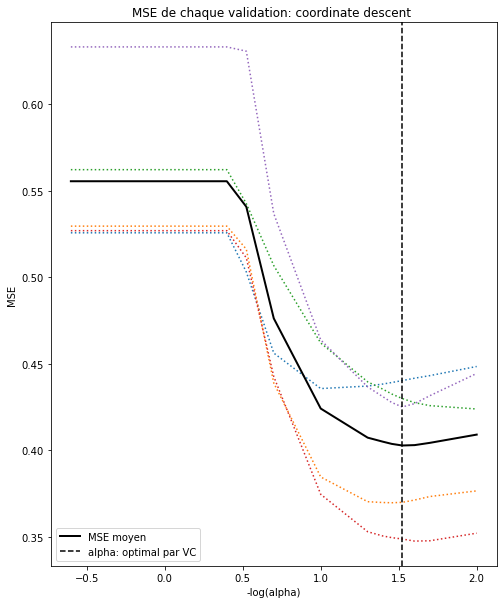

alpha optimal nouvel algo 0.03
alpha optimal trouvé précédemment {'alpha': 0.03}


In [294]:
#from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=[0.01,0.02, 0.025,0.03,0.035, 0.04,0.05,0.1,0.2,0.3,0.4,0.5,1,1.3,1.5,1.6,1.7,1.8,2,4],n_jobs=-1,random_state=13).fit(Xr_train,Yr_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

print("alpha optimal nouvel algo", model.alpha_)
print("alpha optimal trouvé précédemment",regLassOpt.best_params_)

**Q** Vérifier que c'est bien la même valeur optimale que celle précédemment trouvée.

Tracés des chemins de régularisation.

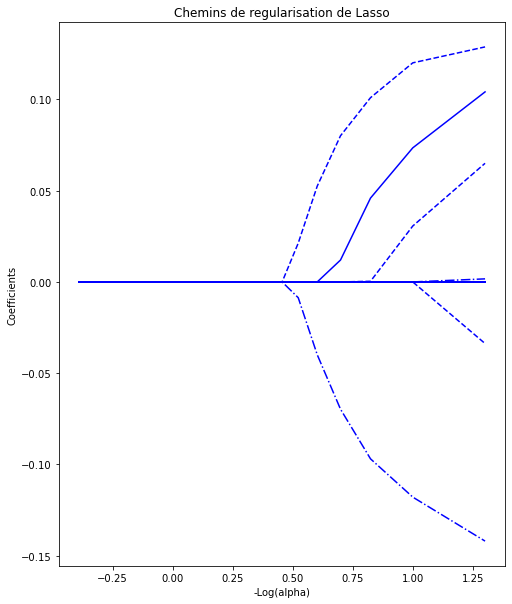

In [295]:
alphas_lasso, coefs_lasso, _ = lasso_path(Xr_train,Yr_train, alphas=np.array(range(1,50,1))/20.,)
plt.figure()
ax = plt.gca()
styles = cycle(['-', '--', '-.', ':'])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
for coef_l, s in zip(coefs_lasso, styles):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle=s,c='b')
    plt.title("Chemins de regularisation de Lasso")
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.show()

<FONT COLOR = "blue"> Ce graphique représente les chemins de régularisation. $\alpha$ est le paramètre de pénalisation dans la regression LASSO. 
On trace pour chaque valeur de $-log (\alpha)$ en abscisse, l'estimation des paramètres de notre modèle contenus dans le vecteur $\hat \theta$. Chaque courbe est une variable de $\hat \theta$. Lorsque la courbe touche 0, le coefficient correspondant dans $\hat \theta$ s'annule.
    
<FONT COLOR = "blue"> Plus $\alpha$ augmente et plus les paramètres du vecteur $\hat \theta$ vont être estimés à 0 (pour que le terme de pénalisation $l_1$ reste constant). Ainsi, plus $\alpha$ augmente et plus on a de coefficients nuls dans $\hat \theta$ donc plus notre estimateur $\hat \theta$ devient sparse.

#### [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf) ou modèle binomial

La même démarche est déroulée mais en modélisant directement la variable binaire Yb de dépassement ou non du seuil. Il s'agit d'une régression logistique avec toujours une pénalisation Lasso pour opérer une sélection de variables.

In [297]:
# Optimisation du paramètre de pénalisation

#Rq : qd la variable à expliquer est multinomiale, 
#LogisticRegression sélectionne par défaut le modèle multinomiale

param=[{"C":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.5,1.7,2,3,4]}] # grille de valeurs
logit = GridSearchCV(LogisticRegression(penalty="l1",solver="liblinear"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(Xr_train, Yb_train)  # GridSearchCV est lui même un estimateur
# paramètre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.452727, Meilleur paramètre = {'C': 0.3}


Le modèle "optimal"  obtenu est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. 

La matrice de confusion croise la quantité de pluie prédite avec celle effectivement observée. 

In [298]:
y_chap = logitOpt.predict(Xr_test) # Prédiction
table=pd.crosstab(y_chap,Yb_test)  # Matrice de confusion
print("Erreurs et performance du modèle logistique pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=", 1-logitOpt.score(Xr_test, Yb_test))
print("pureté=", purity(table))
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))


Erreurs et performance du modèle logistique pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.42028985507246375
pureté= 0.5797101449275363
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          20         9        4
low_rain           13        42       25
no_rain             2         5       18

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.571429
low_rain     0.750000
no_rain      0.382979
dtype: float64


<FONT COLOR = "blue"> **Interprétation matrice de confusion :**
- en colonne : la réalité 
- en ligne la prédiction
    
En comparant les rapports entre les trois lignes, on observe que : 
- Quand on prédit **high_rain** (première colonne) notre modèle n'est pas très bon car il se trompe presque une fois sur deux en prédisant **low_rain**.
- Quand on prédit **low_rain** (deuxième colonne) notre modèle est un peu meilleur, il fournit une prédiction correcte dans 62% des cas. Il fait à peu près le même nombre d'erreur entre **high_rain** et **no_rain** qu'il a prédit respectivement 11 fois et 14 fois.
- Quand on prédit **no_rain** (première colonne) notre modèle n'est pas  bon il ne fournit la bonne prédiction que dans 38% des cas. Il prédit même plus de fois **low_rain** que **no_rain**.
   
**Problème de chiffres non?**

L'interprétation du modèle est basée sur les valeurs des coefficients avec les mêmes difficultés ou restrictions que pour la régression. Attention, `GridSearch` ne retient pas les coefficients, il faut les ré-estimer.

In [299]:
# Coefficients
logitLasso=LogisticRegression(penalty="l1",C=logitOpt.best_params_['C'],
                              solver="liblinear")
logitCoef=logitLasso.fit(Xr_train,Yb_train).coef_
print(logitCoef[0])

[-0.18900519 -0.00390557  0.17173804  0.02504202  0.15118716 -0.08532969
  0.          0.         -0.03426423  0.14862124  0.01311566 -0.01315979
  0.          0.         -0.23529046  0.          0.          0.26345171
 -0.1134382   0.47196446  0.19979446  0.30631494  0.          0.
  0.         -0.12546149 -0.80413753]


In [300]:
coef = pd.Series(logitCoef[0], index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 18 variables et en supprime 9


Text(0.5, 1.0, 'Coefficients du modèle lasso')

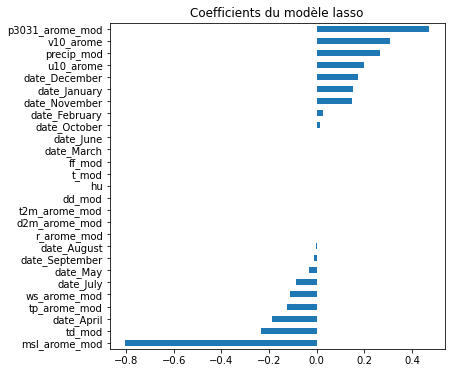

In [301]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

**Q** Interpréter l'effet des variables retenues.

<FONT COLOR="Blue"> **Effets de la regression LASSO :** 

La pénalisation Lasso a permi de supprimer 6 variables et en a conservé 20. 

Parmi les paramètres été sélectionnées on remarque notamment :
- **msl_arome_mod** (pression atmosphérique) et **p3031_arome_mod** (direction du vent) qui sont les deux variables qui ont le plus d'influence. 
- **date** : Toutes les variables qui concernent les mois ont été sélectionnées. Les mois de Novembre et Décembre ont un coefficient positif tandis que les autres ont un coefficient négatif. 
- **precip_mod** (quantité totale des précipitations), **tp_arome_mod** (quantité totale des précipitations prédites par le modèle AROME) et **v10_arome** (composantes du vent d'ouest à est prise à 10m de hauteur) font également partie des variables qui ont le plus d'influence
    
<FONT COLOR="green"> **Effets de la regression LASSO :** 

La pénalisation Lasso a permis de supprimer 15 variables et en a conservé 12. 

Parmi les paramètres qui ont été sélectionnés, on remarque notamment :
- **msl_arome_mod** (pression atmosphérique) et **p3031_arome_mod** (direction du vent) qui sont les deux variables qui ont le plus d'influence. 
- **date** : Les variables qui concernent les mois d'avril, janvier, novembre, décembre ont été sélectionnées. Les mois de janvier, Novembre et Décembre ont un coefficient positif tandis avril négatif. 
- **precip_mod** (quantité totale des précipitations), **tp_arome_mod** (quantité totale des précipitations prédites par le modèle AROME) et **v10_arome** (composantes du vent d'ouest à est prise à 10m de hauteur) font également partie des variables qui ont le plus d'influence.
    
On constate que la sélection de variables dans le cas de la régression et de la régression logistique on des similitudes (on retrouve u10,v10, precip_mod, t_mod, date_december. 
    Cependant p3031_arome_mod a été sélectionné et a un impact important, ce qui peut s'expliquer par le faible nombre de modalités que prend Y (3) dans la régression logistique, que dans la régression avec les variables continues de rain. On a moins d'information quand on utilise une variable qualitative, ce qui peut faire varier la sélection de variables ou leur impact (comme msl_arome_mod qui a un impact négatif important dans la régression logistique alors qu'il avait un impact positif moindre dans la régression normale).
    

# <FONT COLOR="Red">Épisode 2</font>

### [K plus proches voisins](http://wikistat.fr/pdf/st-m-app-add.pdf)

Voici un cas d'application d'analyses discriminantes [non paramétriques](http://scikit-learn.org/stable/modules/neighbors.html), celles [paramétriques](http://scikit-learn.org/stable/modules/lda_qda.html) (gaussienes) linéaires et quadratiques sont également présentes dans *scikit-learn* mais laissées en exercice.

Le paramètre de compléxité ($k$) est optimisé sur une grille prédéfinie en minimisant l'erreur estimée par validation croisée; scikit-learn propose de nombreuses options de validation croisée. 

In [58]:
from sklearn.neighbors import KNeighborsClassifier
# Optimisation de k
# grille de valeurs
param_grid=[{"n_neighbors":list(range(1,15))}]
knn=GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knnOpt=knn.fit(Xr_train, Yb_train)  # GridSearchCV est lui même un estimateur
# paramètre optimal
knnOpt.best_params_["n_neighbors"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-knnOpt.best_score_,knnOpt.best_params_))

Meilleur score = 0.450909, Meilleur paramètre = {'n_neighbors': 12}


In [59]:
# Estimation de l'erreur de prévision sur l'échantillon test
1-knnOpt.score(Xr_test,Yb_test)

0.5

In [60]:
# Prévision de l'échantillon test
y_chap = knnOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print("Erreurs et performance du modèle KNN pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=", 1-knnOpt.score(Xr_test,Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du modèle KNN pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.5
pureté= 0.5
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        11        6
low_rain           12        38       29
no_rain             4         7       12

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.678571
no_rain      0.255319
dtype: float64


**Exercice** Compléter les résultats en utilisant la fonction [KNeighborsRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) pour modéliser la concentration; optimiser $k$, calculer la prévision de l'échantillon test, tracer le graphe des résidus, calculer le MSE sur l'échantillon test.

### [Arbre binaire de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf)

#### Utilisés en classification pour prédire l'intensité de la pluie

<FONT COLOR = "blue">  ***L'utilisation d' arbres binaires de décision*** est une méthode qui ne suppose aucune hypothèse et est non paramétrique. Ils sont très interprétables, mais néanmoins très instables de par leur construction, ce qui justifiera l'utilisation de random forest. 

<FONT COLOR = "blue">La première étape consiste à calculer l'arbre maximal (c'est à dire l'arbre pour lequel chacune des feuilles ne contient que des valeurs Y homogènes). A chaque noeud, on divise selon une variable explicative (et un seuil en régression si la variable explicative est quantitative) qui est choisi tel qu'il minimise la fonction d'hétérogénéité (la somme de l'hérogénéité du noeud gauche et droit, l'hétérogénéité correspondant à l'erreur quadratique pour la régression et la Gini concentration ou le critère de la cross entropy en classification) à chaque noeud. 
    
<FONT COLOR = "blue"> La valeur dans une feuille/noeud terminal de l'arbre correspond à : 
    
   <FONT COLOR = "blue"> - un vote de majorité de toutes les valeurs Y des données qui sont tombées dans la feuille si on est en CLASSIFICATION 
       
   <FONT COLOR = "blue"> -la moyenne de toutes les valeurs Y des données qui sont tombées dans la feuille si on est en REGRESSION. 
    
    
<FONT COLOR = "blue">La seconde étape est une étape d'élaguage appliquée à l'arbre complet/maximal. On minimise D(A)+$\gamma$ Nb_feuilles c'est à dire la somme de l'hétérogénéité dans tout l'arbre en pénalisant avec le nombre de feuilles. Cela permet d'élaguer l'arbre, et l'objectif principal est de découper en deux groupes homogènes en terme de classification à chaque noeud, et de trouver un compromis entre l'arbre maximal et l'arbre constant. 
    
<FONT COLOR = "blue"> Les paramètres à optimiser sont la pronfondeur maximale et on l'optimise en faisant de la cross validation pour calculer l'erreur de généralisation. (d'autres paramètres peuvent aussi être optimisés de cette manière tels que le nombre minimal d'observations dans une feuille). 

In [61]:
from sklearn.tree import DecisionTreeClassifier
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOptclass=tree.fit(Xr_train, Yb_train)
# paramètre optimal

print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOptclass.best_score_,treeOptclass.best_params_))

Meilleur score = 0.498182, Meilleur paramètre = {'max_depth': 3}


Autre difficulté dans la représentation d'un arbre de décision binaire. Le logiciel conseillé (Graphviz) semble délicat d'installation et d'utilisation pour un néophyte. Il est possible de lister la construction des noeuds avec quelques [lignes de commande.](http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)

In [62]:
treeG=DecisionTreeClassifier(max_depth=treeOptclass.best_params_['max_depth']) #on optimise ici selon la profondeur
treeG.fit(Xr_train,Yb_train)
treepred=treeG.predict(Xr_test)#on prédit l'échantillon test

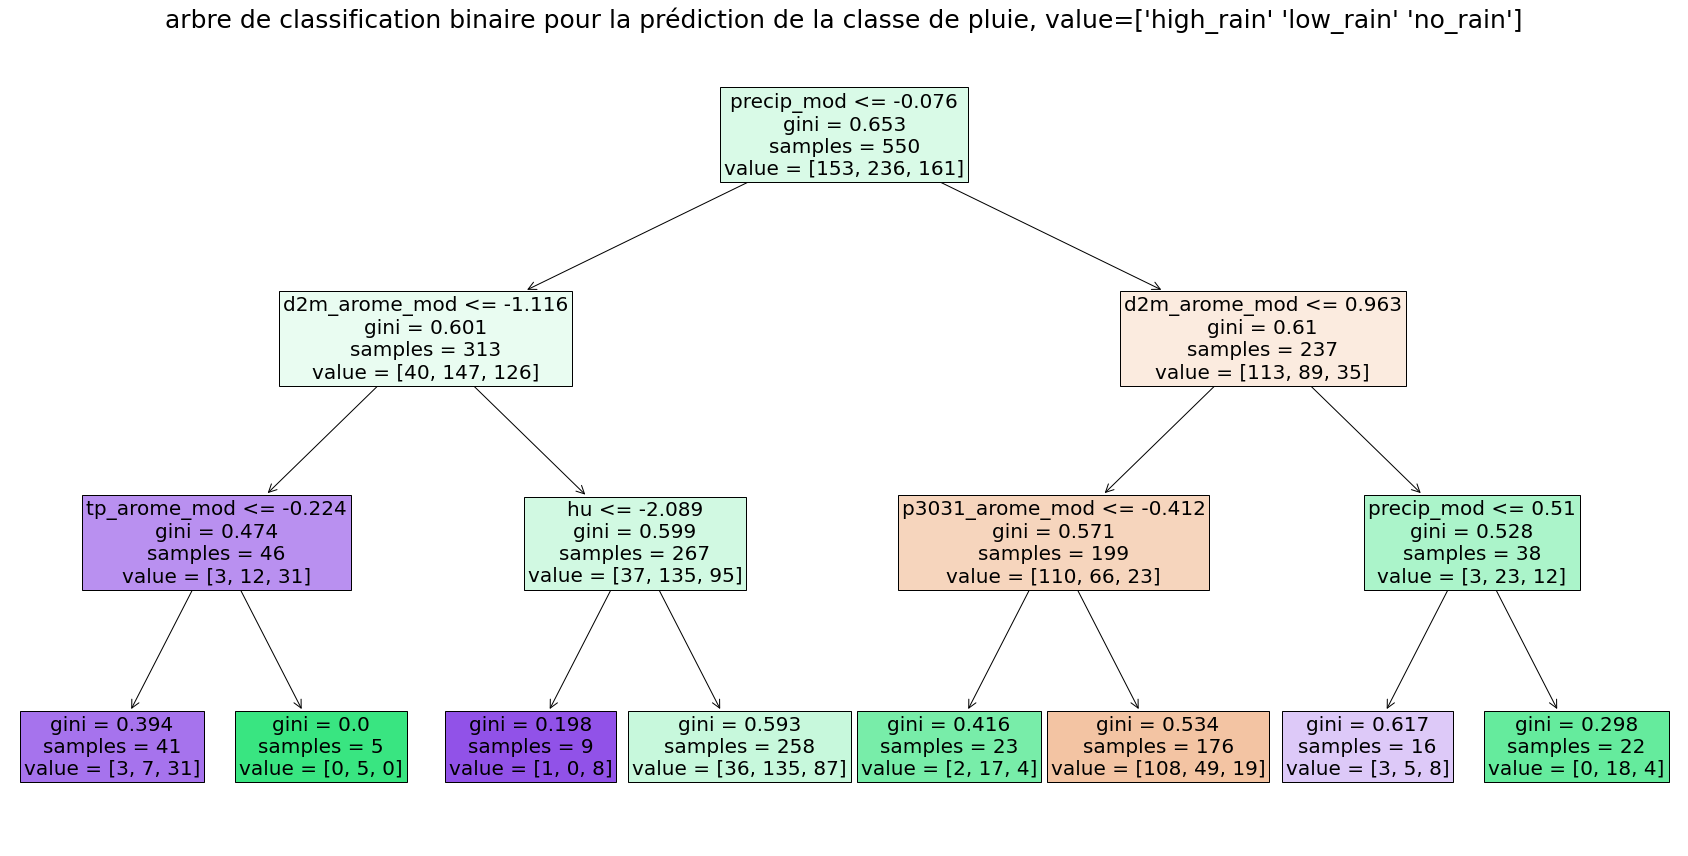

In [63]:
import matplotlib.pyplot as plt
from sklearn import tree
##autre proposition (plus claire pour moi)
plt.figure(figsize=(30,15))
tree.plot_tree(treeG,fontsize=20,feature_names=list(X_train.columns), filled=True)
plt.title("arbre de classification binaire pour la prédiction de la classe de pluie, value="+str(np.unique(list(Yb_train))), fontsize=25)
plt.show()

**Q** Que dire de l'interprétation de l'arbre? Comparer les rôles des variables avec le modèle logit.

<FONT COLOR = "blue">  On obtient l'arbre déterminé en ayant optimisé la profondeur maximale (ici 3). La variable qui a le plus d'importance est la variable qui a permis d'effectuer le premier split, ici precip_mod, ce qui est normal car elle correspond à la quantité totale des précipitations. td_mod et d2m arome_mod ont aussi une grande importance (ici il s'agit des points de rosée). Value correspond à un vecteur avec l'effectif de chaque classe ["high_rain", "low_rain", "no_rain"]. On voit qu'on est pas encore à l'arbre maximal car il y a encore des feuilles où il y a une assez grande hétérogénéité. 

In [64]:

treepred
table=pd.crosstab(treepred,Yb_test)  # Matrice de confusion #selon l'ordinateur mettre list(treepred) et list(Yb_test) ou pas
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))



rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        17        7
low_rain           11        35       21
no_rain             5         4       19

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.625000
no_rain      0.404255
dtype: float64


<font color="blue"> On voit que l'arbre semble avoir une meilleure prédiction moyenne pour chaque classe par rapport à logit. 

In [65]:
# prévision de l'échantillon test

y_chap = treeOptclass.predict(Xr_test)
# matrice de confusion

table=pd.crosstab(y_chap,Yb_test)
print("Erreurs et performance du modèle CART pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=", 1-treeOptclass.score(Xr_test,Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))
print("classe et effectifs")
print(np.unique(Yb_test, return_counts=True))

Erreurs et performance du modèle CART pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.47101449275362317
pureté= 0.5289855072463768
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        17        7
low_rain           11        35       21
no_rain             5         4       19

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.625000
no_rain      0.404255
dtype: float64
classe et effectifs
(array(['high_rain', 'low_rain', 'no_rain'], dtype=object), array([35, 56, 47]))


In [66]:
import re 
from sklearn.tree import export_text
rtreeclass = export_text(treeG.fit(Xr_train,Yb_train), feature_names=list(dfC.columns))
print("affichage d' un résumé de la construction de l'arbre plus lisible")
print(rtreeclass)

affichage d' un résumé de la construction de l'arbre plus lisible
|--- precip_mod <= -0.08
|   |--- d2m_arome_mod <= -1.12
|   |   |--- tp_arome_mod <= -0.22
|   |   |   |--- class: no_rain
|   |   |--- tp_arome_mod >  -0.22
|   |   |   |--- class: low_rain
|   |--- d2m_arome_mod >  -1.12
|   |   |--- hu <= -2.09
|   |   |   |--- class: no_rain
|   |   |--- hu >  -2.09
|   |   |   |--- class: low_rain
|--- precip_mod >  -0.08
|   |--- d2m_arome_mod <= 0.96
|   |   |--- p3031_arome_mod <= -0.41
|   |   |   |--- class: low_rain
|   |   |--- p3031_arome_mod >  -0.41
|   |   |   |--- class: high_rain
|   |--- d2m_arome_mod >  0.96
|   |   |--- precip_mod <= 0.51
|   |   |   |--- class: no_rain
|   |   |--- precip_mod >  0.51
|   |   |   |--- class: low_rain



#### Utilisés en régression : prédire la quantité de pluie rain

In [67]:
param=[{"max_depth":list(range(1,10))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOptr=tree.fit(Xr_train, Yr_train)
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOptr.best_score_,treeOptr.best_params_))

Meilleur score = 0.856855, Meilleur paramètre = {'max_depth': 2}


In [68]:
treeR=DecisionTreeRegressor(max_depth=treeOptr.best_params_['max_depth']) #on optimise ici selon la profondeur
treeR.fit(Xr_train,Yr_train)
dot_data = StringIO() 
export_graphviz(treeR, out_file=dot_data) 
graph=pydotplus.graph_from_dot_data(dot_data.getvalue()) 
#graph.write_png("treeOpt.png")  

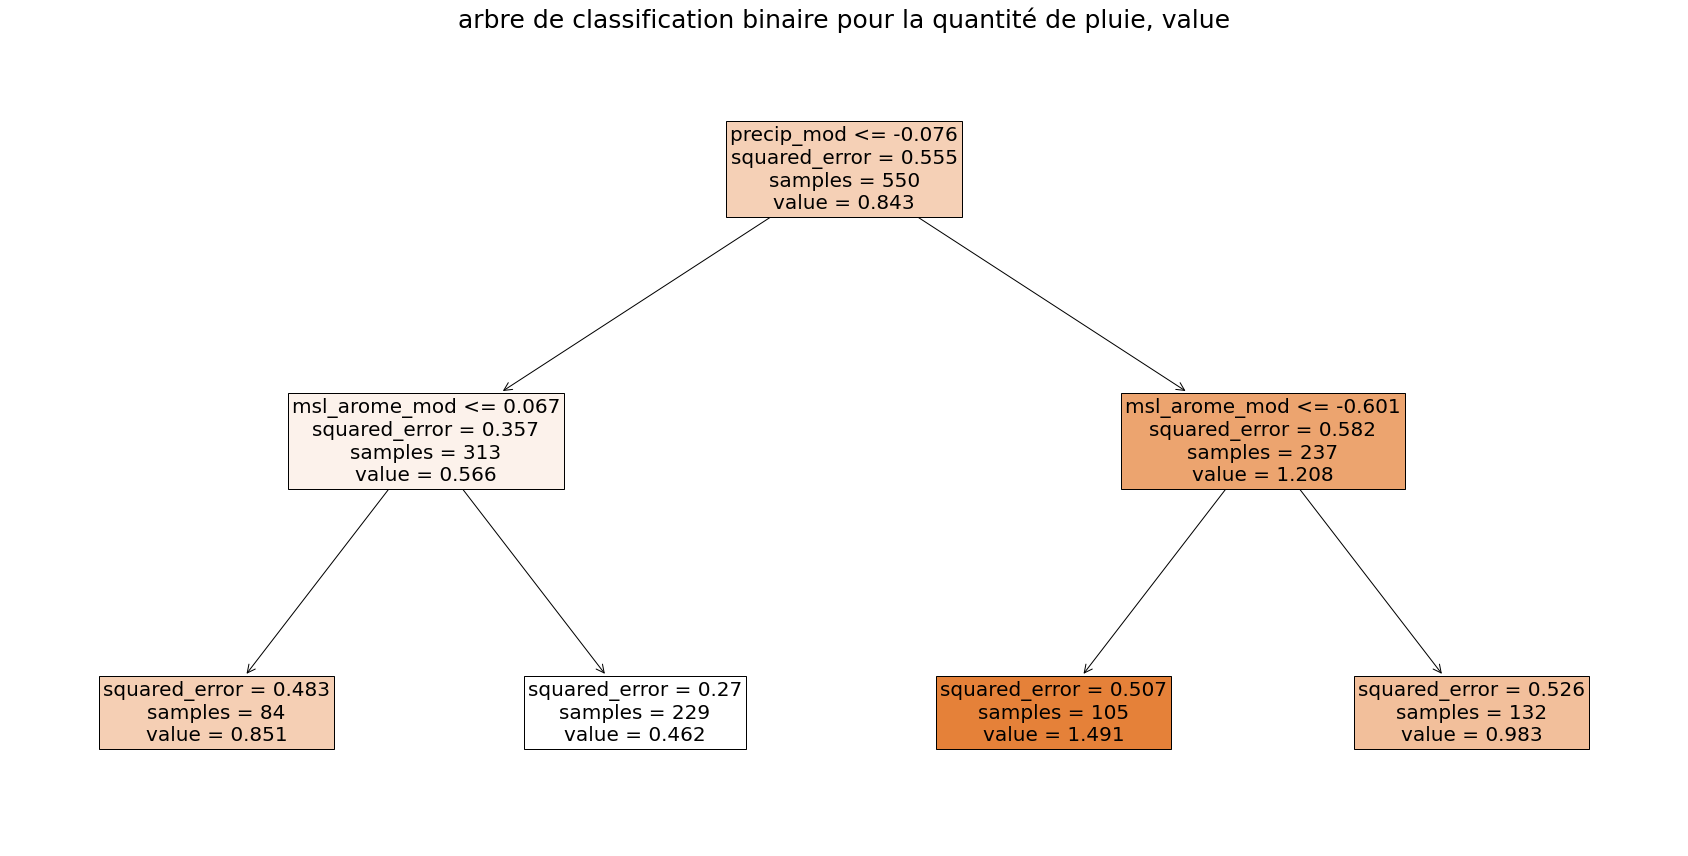

In [69]:
import matplotlib.pyplot as plt
from sklearn import tree #autre possibilité
##autre proposition (plus claire pour moi)
plt.figure(figsize=(30,15))
tree.plot_tree(treeR,fontsize=20,feature_names=list(X_train.columns), filled=True)
plt.title("arbre de classification binaire pour la quantité de pluie, value", fontsize=25)
plt.show()

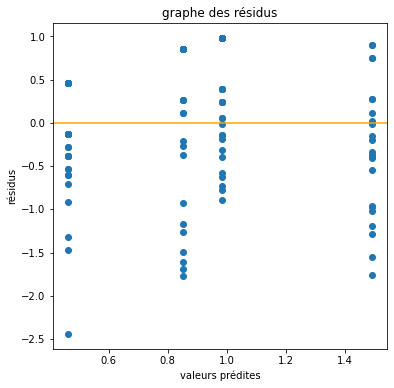

In [70]:
treepredreg=treeR.predict(Xr_test)#on prédit l'échantillon test
treeres=treepredreg-list(Yr_test)#résidus 
plt.plot(treepredreg,treeres, "o") 
plt.title ("graphe des résidus")
plt.ylabel("résidus")
plt.xlabel("valeurs prédites")
plt.axhline(c="orange")

In [71]:
print("Erreurs et performance du modèle CART pour prédire la quantité de précipitations ici Rain_mod")
print("-------------------------------------------------------------------")
print("MSE=",mean_squared_error(Yr_test,treepredreg))
print("MAPE=", MAPE(list(Yr_test), treepredreg))
print("erreur généralisation Python = ", 1-treeOptr.score(Xr_test,Yr_test))

Erreurs et performance du modèle CART pour prédire la quantité de précipitations ici Rain_mod
-------------------------------------------------------------------
MSE= 0.5200324138890837
MAPE= 36.65441854042261
erreur généralisation Python =  0.7493191623946147


<font color="blue"> La structure particulière du graphe est due au fait que les prédictions sont constantes par morceaux. Il y a autant de prédictions que de feuilles/noeuds terminaux. Cela explique la forme striée du graphe (en abscisse chaque valeur correspond à la valeur d'un noeud terminal). Cela peut amplifier l'erreur, est explique le fait que les résidus ne sont pas tous très proches de 0. La variance varie également un peu.  C'est ici que random forest peut avoir un avantage important car il permettra de faire des prédictions avec plusieurs arbres et de moyenner la sortie. 

In [72]:
mseregarbre=np.sum(( treepredreg-list(Yr_test))**2) /len(treepredreg) #calcul du mse

In [73]:
class_tree_post_regression=np.ones((np.shape(treepredreg)[0],1))
class_tree_post_regression[np.where(treepredreg>2)]=2
class_tree_post_regression[np.where(treepredreg==0)]=0
#no_rain (si rain=0), -low_rain (si 0<rain<2), -high_rain (si rain>2)

In [74]:

rtreeReg= export_text(treeR.fit(Xr_train,Yr_train), feature_names=list(dfC.columns))
print("affichage d' un résumé de la construction de l'arbre plus lisible")
print(rtreeReg)

affichage d' un résumé de la construction de l'arbre plus lisible
|--- precip_mod <= -0.08
|   |--- msl_arome_mod <= 0.07
|   |   |--- value: [0.85]
|   |--- msl_arome_mod >  0.07
|   |   |--- value: [0.46]
|--- precip_mod >  -0.08
|   |--- msl_arome_mod <= -0.60
|   |   |--- value: [1.49]
|   |--- msl_arome_mod >  -0.60
|   |   |--- value: [0.98]



### Méthodes d'agrégation

#### [Forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

La librairie *randomForest* de R utilise le programme historique développé par [Breiman et Cutler](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_software.htm)(2001) et interfacé  par [Liaw et Wiener](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf). Cette interface est toujours mise à jour mais il n'est pas sûr que le programme original continue d'évoluer depuis 2004. Pour des tailles importantes d'échantillons, quelques milliers, cette implémentation atteint des temps d'exécution rédhibitoires (cf. cet [exemple](https://github.com/wikistat/Ateliers-Big-Data/blob/master/2-MNIST/Atelier-MNIST-R.ipynb)) au contraire de celle en Python dont gestion mémoire et capacité de parallélisation ont été finement optimisées par [Louppe et al.](http://fr.slideshare.net/glouppe/accelerating-random-forests-in-scikitlearn)(2014). 

De même que le boosting, deux fonctions  de forêt sont proposés dans [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html) ; une pour la régression et une pour la classification ainsi qu'une version "plus aléatoire". Par rapport à la version originale de R, moins d'options sont proposées mais l'utilisation de base est très similaire avec le même jeu de paramètres.

**Q20** Identifier les paramètres, les valeurs par défaut.

<font color="blue"> Principe du `random forest` : Cette technique permet de réduire l'instabilité du modèle CART. Elle met en oeuvre une technique de bootstrapping de manière à tirer aléatoirement et avec remise B échantillons de taille n, de manière à construire B arbres CART. A chaque noeud, m parmi les p variables explicatives $(m<p)$ sont choisies aéatoirement, et le split ne peut se faire qu'en fonction d'elles. Cela permet de choisir des variables de séparation, qui n'auraient pas été choisies car il y en aurait eu des meilleurs sinon, et permet aussi d'obtenir une diversité d'arbres.Ensuite on fait une étape d'agrégation c'est à dire que pour chaque x_0 qu'on souhaite prédire, on prédit pour chaque arbre la valeur $\hat{Y}$ (comme pour les arbres). Ensuite, en classification, on fait un vote de majorité parmi tous les $\hat{Y}$. Sinon, si on est en régression on fait la moyenne entre tous les $\hat{Y}$ prédits par les B arbres.

<font color="blue"> Rappel sur les out of bag : individus qui n'ont pas été tirés dans l'étape de bootstrapping. On peut calculer l'erreur de généralisation grâce à cela. 

<font color="blue">  Variables à paramétrer : nombre d'arbres, profondeur maximale, nombre minimal et maximal d'individus dans une feuille, le nombre de features m qui peut etre chosii à chaque noeud.... Elles peuvent être optimisées par cross validation (ou aussi en utilisant l'erreur de généralisation obtenue par l'out of bag error). 


##### Utilisation des randoms forest dans un contexte de classification 

In [75]:
from sklearn.ensemble import RandomForestClassifier 
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
#une technique de boostrap est mise en oeuvre de manière à construire 500 arbres, 
#gini est utilisé comme critère d'hétérogénéité et l'out of bag score est renvoyé
# apprentissage
rfFit = forest.fit(Xr_train,Yb_train)
print("OOB error", 1-rfFit.oob_score_) #Return the error of generalisation (1-accuracy) ATTENTION

OOB error 0.5018181818181818


Comparer l'erreur out-of-bag ci-dessus avec celle sur l'échantillon test.

In [76]:
# erreur de prévision sur le test
1-rfFit.score(Xr_test,Yb_test)

0.4347826086956522

Optimisation par validation croisée du nombre de variables tirés aléatoirement lors de la construction de chaque noeud. 

In [77]:
param=[{"max_features":list(range(2,10,1)), "n_estimators":np.arange(100,300,100)}]
rf= GridSearchCV(RandomForestClassifier(),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.472727, Meilleur paramètre = {'max_features': 2, 'n_estimators': 100}


Plusieurs exécutions, rendues aléatoires par la validation croisée, peuvent conduire à des valeurs "optimales" différentes de ce paramètre sans pour autant nuire à la qualité de prévision sur l'échantillon test.

In [78]:
# prévision
y_chap = rfFit.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)

print("Erreurs et performance du modèle RF pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=",1-rfOpt.score(Xr_test,Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du modèle RF pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.4347826086956522
pureté= 0.5652173913043478
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19        11        5
low_rain           14        38       21
no_rain             2         7       21

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.678571
no_rain      0.446809
dtype: float64


Comme avec R, il est possible de calculer un indicateur d'importance des variables pour aider à une forme d'interprétation. Celui-ci dépend de la position de la variable dans l'arbre et correspond donc au *mean decrease in Gini index* de R plutôt qu'au *mean descrease in accuracy*. La forêt doit être réestimée car GridSearch ne connaît pas le paramètre d'importance.

In [79]:
rf= RandomForestClassifier(n_estimators=100,max_features=2)
rfFit=rf.fit(Xr_train, Yb_train)
# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(Xr_train.shape[1]):
    #print(f)
    print(dfC.columns[indices[f]], importances[indices[f]])

msl_arome_mod 0.07894066312851199
u10_arome 0.06358476926189445
p3031_arome_mod 0.06336976506072652
t2m_arome_mod 0.06193026836987526
hu 0.06146550904960364
d2m_arome_mod 0.06130606243566381
v10_arome 0.06117862939567252
tp_arome_mod 0.06089461593603957
r_arome_mod 0.06089359117226672
precip_mod 0.05983491593799916
t_mod 0.05849088623396938
ws_arome_mod 0.058332119906347214
dd_mod 0.05734924628344437
td_mod 0.056058709281085556
ff_mod 0.05566783637054889
date_January 0.009115528564086059
date_November 0.008477111426639893
date_April 0.007606969818632411
date_March 0.007260786377058609
date_August 0.00701868455106768
date_May 0.006503475372660959
date_June 0.006397044096658251
date_September 0.0060836997563839205
date_July 0.0058621881998173085
date_October 0.0056147544660963555
date_February 0.005573529589247995
date_December 0.0051886399580014534


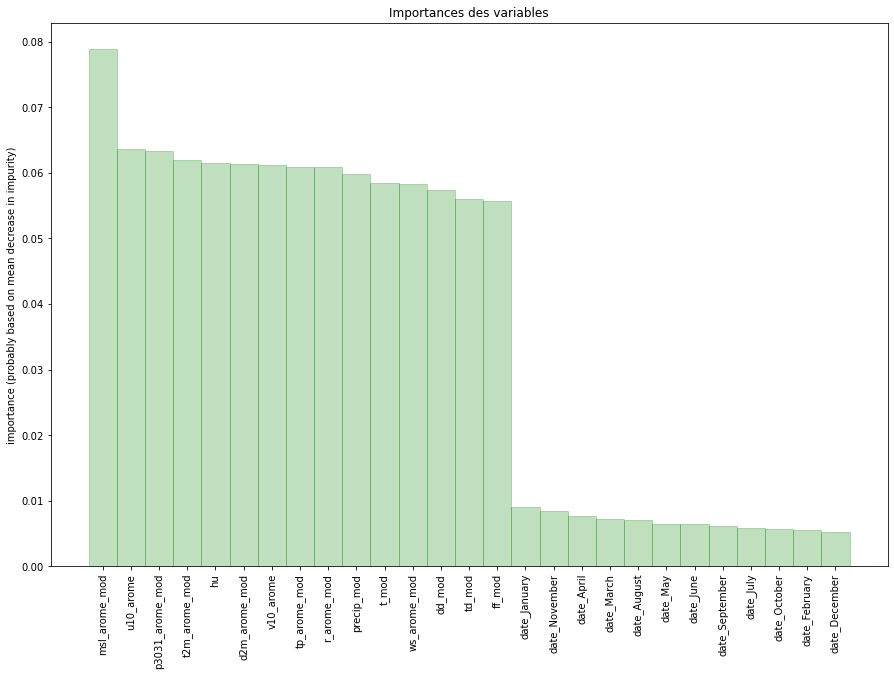

In [80]:
# Graphe des importances
plt.figure(figsize=((15,10)))
plt.bar(list(dfC.columns[indices]), importances[indices] ,1, color='g', edgecolor="g", alpha=0.25)
plt.title("Importances des variables")
plt.ylabel("importance (probably based on mean decrease in impurity)")
plt.xticks(rotation=90)
plt.show()

**Q** Comparer les importances des variables et les sélections opérées précédemment. 

<font color="blue"> Dans Python, le critère d'importance est la Gini importance. Ils sont calculés après avoir construit notre foret (car on ne peut pas comme pour les arbres prendre la variable le plus en haut car on a plusieurs arbres). On prend la variable qui la plus grand importance. Ici, il s'agit de msl.arome_mod correspondant à la pression atmosphérique prédite par le modèle de météo france (variable qui n'avait pas été choisie par l'arbre mais qui a été choisie ici grâce au tirage aléatoire de m variable à chaque noeud). 

**Exercice** Remplacer ensuite la fonction RandomForestClassifier par celle [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de régression. Optimiser le paramètre, calculer la prévision, les résidus, le MSE.

**Exercice** Expérimenter également le boosting sur ces données en exécutant la fonction [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) opérant l'agorithme de *gradient tree boosting*. 

**Remarque:** Une version "améliorée" de *boosting* mieux paralélisée et incluant d'autres paramètres (pénalisation), est  proposé dans le package: [`XGBoost`](https://xgboost.readthedocs.io/en/latest/build.html#python-package-installation) qui peut être utilisé à partir de Python mais aussi R, Julia ou Java. Nénamoins le choix est fait d'arrêter l'acharnement sur ces données; `XGBoost` est testé en python sur un autre jeu de données. 

##### Utilisation des random forest en régression

In [81]:
from sklearn.ensemble import RandomForestRegressor
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500, 
    max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
rfFitreg = forest.fit(Xr_train,Yr_train) 
print("erreur out of bag", 1-rfFitreg.oob_score_) #on calcule l'erreur out of bag. 

erreur out of bag 0.7470090310964465


<font color="blue">  Avec calibration des paramètres par cross validation 5 folds

In [82]:
param=[{"n_estimators":[100,500,1000], "max_features":list(range(2,10,1)), "max_depth":list(range(2,10,1))}]#optimisation de m, correspondant à max_features, noeudmbde de variabl
rf= GridSearchCV(RandomForestRegressor(bootstrap=True),
        param,cv=5,n_jobs=-1)
rfOptreg=rf.fit(Xr_train, Yr_train)
# paramètre optimal
print("Erreur = %f, Meilleur paramètre = %s" % (1. - rfOptreg.best_score_,rfOptreg.best_params_))

Erreur = 0.742592, Meilleur paramètre = {'max_depth': 8, 'max_features': 5, 'n_estimators': 500}


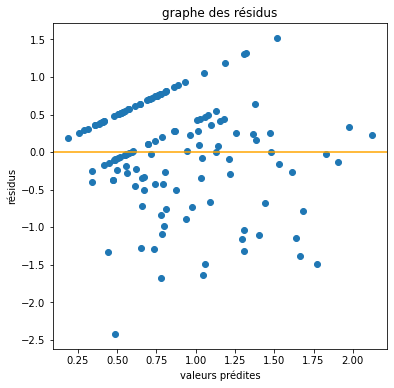

In [83]:
rfregpred=rfOptreg.predict(Xr_test)#on prédit l'échantillon test
treeres=rfregpred-list(Yr_test)#résidus 
plt.plot(rfregpred,treeres, "o") 
plt.title ("graphe des résidus")
plt.ylabel("résidus")
plt.xlabel("valeurs prédites")
plt.axhline(c="orange")

In [84]:
mserfreg=np.sum((rfregpred-list(Yr_test))**2) /len(rfregpred) #calcul du mse, à véirfier 

print("Erreurs et performance du modèle RF pour prédire la quantité de précipitations ici Rain_mod")
print("-------------------------------------------------------------------")
print("MSE=",mean_squared_error(Yr_test,rfregpred))
print("MAPE=", MAPE(list(Yr_test), rfregpred))

print("erreur généralisation Python = ", 1-rfOptreg.score(Xr_test,Yr_test))

Erreurs et performance du modèle RF pour prédire la quantité de précipitations ici Rain_mod
-------------------------------------------------------------------
MSE= 0.4737893342713723
MAPE= 34.4705345062054
erreur généralisation Python =  0.6826871126218835


In [85]:
rfOptregbis=RandomForestRegressor(bootstrap=True, max_depth=rfOptreg.best_params_["max_depth"], max_features=rfOptreg.best_params_["max_features"], n_estimators=rfOptreg.best_params_["n_estimators"])
rfOptreg.best_params_

{'max_depth': 8, 'max_features': 5, 'n_estimators': 500}

In [86]:
# Importance décroissante des variables

rfOptregbis.fit(Xr_train, Yr_train)
importancesreg = rfOptregbis.feature_importances_
indicesreg = np.argsort(importancesreg)[::-1]
for f in range(Xr_train.shape[1]):
    print(dfC.columns[indicesreg[f]], importances[indicesreg[f]])

msl_arome_mod 0.07894066312851199
precip_mod 0.05983491593799916
tp_arome_mod 0.06089461593603957
v10_arome 0.06117862939567252
u10_arome 0.06358476926189445
ws_arome_mod 0.058332119906347214
p3031_arome_mod 0.06336976506072652
dd_mod 0.05734924628344437
ff_mod 0.05566783637054889
t_mod 0.05849088623396938
td_mod 0.056058709281085556
t2m_arome_mod 0.06193026836987526
hu 0.06146550904960364
d2m_arome_mod 0.06130606243566381
r_arome_mod 0.06089359117226672
date_February 0.005573529589247995
date_April 0.007606969818632411
date_January 0.009115528564086059
date_May 0.006503475372660959
date_November 0.008477111426639893
date_December 0.0051886399580014534
date_September 0.0060836997563839205
date_March 0.007260786377058609
date_June 0.006397044096658251
date_August 0.00701868455106768
date_July 0.0058621881998173085
date_October 0.0056147544660963555


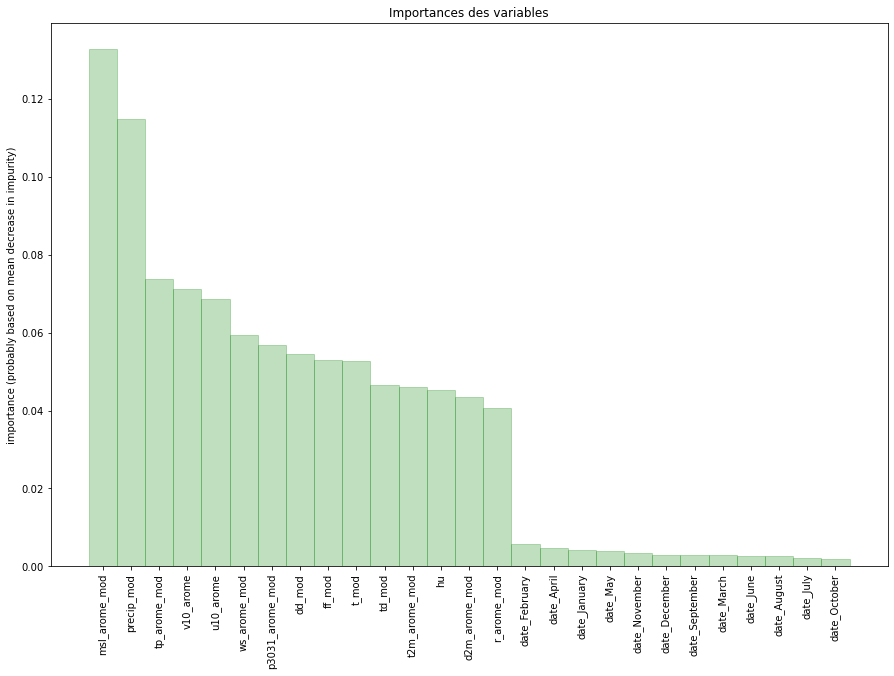

In [87]:
plt.figure(figsize=((15,10)))
plt.bar(list(dfC.columns[indicesreg]), importancesreg[indicesreg],1, color='g', edgecolor="g", alpha=0.25)
plt.title("Importances des variables")
plt.ylabel("importance (probably based on mean decrease in impurity)")
plt.xticks(rotation=90)
plt.show()

#### Méthode de boosting 

<font color="blue"> Une autre manière de faire de l'agrégation de modèles est d'utiliser le boosting. Il s'agit de réaliser une combinaison linéaire d'une séquence récursive de prédicteurs faibles où chaque prédicteur, pondéré par un certain poids, est une version adaptée du prédicteur précédent. L'aggrégation permet réduire la variance et le biais des prédicteurs. A chaque étape n des poids plus importants sont mis sur les données qui ont mal été prédits par le prédicteur n-1
    
    
<font color="blue">L'algorithme historique Adaboost est dédié à la classification binaire et minimise une fonction perte exponentielle. Le Gradient Boosting Models  (GBM) est une amélioration d' Adaboost. Cet algorithme repose toujours sur une agrégation de prédicteurs où chaque prédicteur agrégé constitue une étape conduisant à une amélioration de la prédiction. La différence réside dans le fait que cette étape est faite en direction du gradient de la fonction perte, le gradient étant lui-même approximé par un arbre de régression. Cette méthode s'applique aussi bien en régression qu'en classification. 
Pour l'algorithme GBM, paramètres à calibrer sont :
    
<font color="blue">- La valeur du  shrinkage. Le shrinkage permet d'éviter le surajustement en redimensionnant la contribution de chaque arbre intervenant dans GBM par un facteur $\nu$ 
- <font color="blue">La profondeur de l'arbre à calibrer par cross-validation
- <font color="blue"> Le nombre d'itérations $M$. En effet, chaque itération de l'algorithme de boosting réduit la perte empirique et une valeur de $M$ trop importante mène à du surajustement. Une façon de calibrer ce paramètre est d'estimer l'erreur de généralisation sur un échantillon de validation (par exemple en utilisant la validation croisée) et de choisir la valeur de $M$ qui minimise cette erreur ou de faire de l'early stopping c'est à dire interrompre l'entraînement d'un modèle quand la perte d'un ensemble de données de validation commence à augmenter et que les performances sur le test se dégradent.

##### Classification

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [89]:
# long
param=[{"learning_rate":[0.0001+i*0.001 for i in range (0,15)],"max_depth":np.arange(2,6,1)}]#optimisation de max depth et du learning rate
clfOpt = GridSearchCV(GradientBoostingClassifier(n_estimators=75, random_state=0, loss= "deviance"),  param, cv=5).fit(Xr_train,Yb_train)
print(clfOpt.score(Xr_test,Yb_test))
print("erreur généralisation la plus basse = %f, Meilleur paramètre = %s" % (clfOpt.best_score_,clfOpt.best_params_))

0.6086956521739131
erreur généralisation la plus basse = 0.503636, Meilleur paramètre = {'learning_rate': 0.0091, 'max_depth': 4}


In [90]:
y_chap =clfOpt.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print("Erreurs et performance du modèle Boosting pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=",1-clfOpt.score(Xr_test, Yb_test))#Return the error of generalisation (1-accuracy) ATTENTION
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))
# prévision

Erreurs et performance du modèle Boosting pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.3913043478260869
pureté= 0.6086956521739131
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          19         7        4
low_rain           13        44       22
no_rain             3         5       21

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.542857
low_rain     0.785714
no_rain      0.446809
dtype: float64


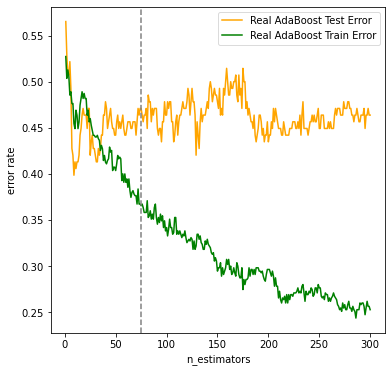

In [91]:
n_estimators = 300
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.0

from sklearn.metrics import zero_one_loss
ada_real = AdaBoostClassifier(
    
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R",
)

ada_real.fit(Xr_train, Yb_train)
fig = plt.figure()
ax = fig.add_subplot(111)



ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(Xr_test)):
    ada_real_err[i] = zero_one_loss(y_pred, Yb_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(Xr_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, Yb_train)

ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err,
    label="Real AdaBoost Test Error",
    color="orange",
)
ax.plot(
    np.arange(n_estimators) + 1,
    ada_real_err_train,
    label="Real AdaBoost Train Error",
    color="green",
)


ax.set_xlabel("n_estimators")
ax.set_ylabel("error rate")
plt.axvline(x=75,color='gray',linestyle='--')
leg = ax.legend(loc="upper right", fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

<font color="blue"> On utilise la méthode d'early stopping, on prend là où le courbe est minimale pour le test et ou ça commence à diverger entre les 2 courbes pour éviter l’overfitting. On fixe donc le nombre de prédicteurs/nombre d'itérations à 75, juste avant la divergence entre les deux courbes.

<font color="blue"> Maintenant qu'on a déterminé le nb d'estimateurs (équivalent au nombre d'arbres) déterminons le learning rate optimal et la profondeur d'arbres optimale, arbres construit à chaque étape du boosting. 

In [92]:
param=[{"learning_rate":np.linspace(0.0001, 0.5,5), "n_estimators":np.arange(1, 600, 100)}]#optimisation de m
clf= GridSearchCV(AdaBoostClassifier(),
        param,cv=5,n_jobs=-1)
clfOptada=clf.fit(Xr_train, Yb_train)

# paramètre optimal
print("erreur généralisation la plus basse = %f, Meilleur paramètre = %s" % (1. - clfOptada.best_score_,clfOptada.best_params_))

erreur généralisation la plus basse = 0.492727, Meilleur paramètre = {'learning_rate': 0.125075, 'n_estimators': 101}


<font color ="blue"> On choisit ici par early stopping le nombre d'estimateurs (le nombre d'arbres) et on voit que prendre n\_estimateurs=50 a lieu juste avant la divergence des deux courbes

In [93]:
predictions = clfOpt.predict(Xr_test)
predictions
from sklearn.metrics import classification_report
print(classification_report(Yb_test,clf.predict(Xr_test)))

              precision    recall  f1-score   support

   high_rain       0.67      0.69      0.68        35
    low_rain       0.53      0.73      0.61        56
     no_rain       0.75      0.38      0.51        47

    accuracy                           0.60       138
   macro avg       0.65      0.60      0.60       138
weighted avg       0.64      0.60      0.59       138



In [94]:
clf.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__algorithm': 'SAMME.R',
 'estimator__base_estimator': None,
 'estimator__learning_rate': 1.0,
 'estimator__n_estimators': 50,
 'estimator__random_state': None,
 'estimator': AdaBoostClassifier(),
 'n_jobs': -1,
 'param_grid': [{'learning_rate': array([1.00000e-04, 1.25075e-01, 2.50050e-01, 3.75025e-01, 5.00000e-01]),
   'n_estimators': array([  1, 101, 201, 301, 401, 501])}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [95]:
param=[{"learning_rate":np.linspace(0.0001, 1,20)}]#optimisation de m
clf= GridSearchCV(AdaBoostClassifier( n_estimators=70),
        param,cv=5,n_jobs=-1)
clfOptada=clf.fit(Xr_train, Yb_train)

In [96]:
print(1-clfOptada.score(Xr_train, Yb_train))

0.43272727272727274


##### Regression

<font color="blue"> Optimisation par early stopping du nombre de prédicteurs (ici d'abres utilisés)

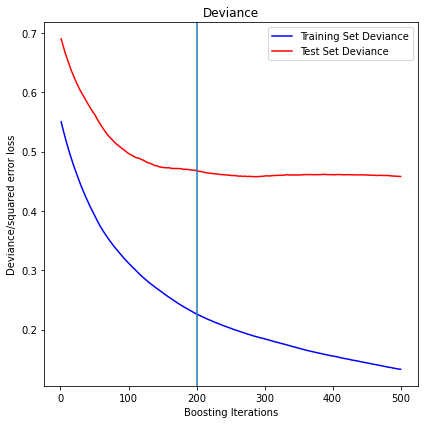

In [97]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(**params)
reg.fit(Xr_train, Yr_train)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

for i, y_pred in enumerate(reg.staged_predict(Xr_test)):
    test_score[i] = reg.loss_(Yr_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)

#plt.axvline((np.arange(params["n_estimators"]) + 1)[np.argmin(test_score)])
plt.axvline(200)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance/squared error loss")
fig.tight_layout()
plt.show()



<font color="blue"> On utilise la méthode d'early stopping, on prend là où le courbe est minimale pour le test et ou ca commence à diverger entre les 2 courbes pour éviter l’overfitting. On fixe donc le nombre de prédicteurs/nimbre d'itérations à 200, juste avant la divergence entre les deux courbes. 

In [98]:
# définition des paramètres

# apprentissage
from sklearn.ensemble import GradientBoostingRegressor


param=[{"learning_rate":[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1], "max_depth": np.arange(2,20,3)}]#optimisation de m
rf= GridSearchCV(GradientBoostingRegressor(n_estimators=200),
        param,cv=5,n_jobs=-1)
boostOpt=rf.fit(Xr_train, Yr_train)

# paramètre optimal
print("Error la moins élevée = %f, Meilleur paramètre = %s" % (1. -boostOpt.best_score_,boostOpt.best_params_)) #1-R^2

Error la moins élevée = 0.755120, Meilleur paramètre = {'learning_rate': 0.02, 'max_depth': 2}


##### Comparaison des forêts aléatoires, arbres, boosting  

In [99]:
print("Erreurs et performance du modèle Boosting pour prédire Rain_mod")
print("-------------------------------------------------------------------")

print("erreur généralisation en Python= ", 1-boostOpt.score(Xr_test, Yr_test))
boostpred=boostOpt.predict(Xr_test)
mseboostreg=np.sum(( boostpred-list(Yr_test))**2) /len(boostpred) 
print("MSE= ", mserfreg)
print("MAPE = ",MAPE(boostpred, list(Yr_test)))

Erreurs et performance du modèle Boosting pour prédire Rain_mod
-------------------------------------------------------------------
erreur généralisation en Python=  0.6633254771042226
MSE=  0.4737893342713723
MAPE =  29.0336784429097


In [100]:
rfpredcalcul=rfOptreg.predict(Xr_test)
treeRcalcul=treeR.predict(Xr_test)
ar = np.array([[list(map(str, rtreeclass.split('\n', 1)[0].split()))[1],1-treeOptclass.score(Xr_test,Yb_test),"_","_"],[list(map(str, rtreeReg.split('\n', 1)[0].split()))[1],1-treeR.score(Xr_test,Yr_test),mseregarbre, MAPE(treeRcalcul,list(Yr_test))], [dfC.columns[indicesreg][0], 1-rfOptreg.score(Xr_test, Yr_test), mserfreg,  MAPE(rfpredcalcul,list(Yr_test))], [dfC.columns[indices][0], 1-rfFit.score(Xr_test,Yb_test), "_", "_"],["_",1-boostOpt.score(Xr_test, Yr_test),mseboostreg, MAPE(boostpred, list(Yr_test))],["_",1-clfOpt.score(Xr_test, Yb_test),"_", "_"], ["_",1-clfOptada.score(Xr_test, Yb_test),"_", "_"]])
df = pd.DataFrame(ar, index = ["Tree Classification", "Tree régression", 'Random forest regression', 'Random Forest classification', 'boosting régression', 'Gradient boosting classification', 'Ada Boosting classification'], columns = ['variable la plus importante', 'erreur de généralisation sur le test', "mse", "MAPE"])
df

,variable la plus importante,erreur de généralisation sur le test,mse,MAPE
Tree Classification,precip_mod,0.47101449275362317,_,_
Tree régression,precip_mod,0.7493191623946147,0.5200324138890837,31.682167016102106
Random forest regression,msl_arome_mod,0.6826871126218835,0.4737893342713723,29.164699230728058
Random Forest classification,msl_arome_mod,0.46376811594202894,_,_
boosting régression,_,0.6633254771042226,0.46035223221873944,29.0336784429097
Gradient boosting classification,_,0.3913043478260869,_,_
Ada Boosting classification,_,0.42028985507246375,_,_


<font color="blue"> Par le tableau, on voit que les erreurs sur l'échantillon test sont moins importantes dans le cas de la régression que dans le cas de la classification. Les arbres et les forêts dans le cadre de la classification sont dans notre cas très peu performants, le modèle n'arrivant pas bien à faire des prédictions.  
Pour comparer les méthodes CART et les méthodes d'agrégation, on voit tout d'abord que la variable la plus importante n'est pas la même pour les deux types de modèles. Que ce soit en classification ou en régression pour les arbres CART, precip_mod est conservée, il s'agit de la quantité totale des précipitations du jour j. Rain_class et rainmod étant les prévisions de précipitations du jour suivant, cela semble normal. 
    
<font color="blue"> Que ce soit en classfication ou en régression pour les random forest, la pression atmosphérique prédite par météo France (en P a) (msl_arome_mod) est conservée. La variable la plus importante est donc la pression atmosphérique prédite pour le jour suivant qui aurait un impact sur les précipitations le lendemain. Msl_arome_mod est une variable qui est très corrélée avec un grand nombre de variables explicatives (comme precip mod) comme on l'avait vu précédemment dans le graphe des corrélations. C'est aussi une variable qui avait été conservée dans le modèle de régression pénalisé avec Lasso. 

<font color="blue"> On remarque que les erreurs sont plus importantes avec les modèles agrégés qu'avec les modèles d'arbre. Cela est surprenant car les arbres sont particulièrement instables, alors que les random forest, grâce aux techniques de boostrapping et de sélection de variables aléatoires à chaque noeud permet de mieux prendre en compte l'ensemble des variables et de faire diminuer la variance. 

# <FONT COLOR="Red">Épisode 3</font>

### [Réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

Les réseaux neuronaux (perceptron multicouche) ne sont présents dans le package `Scikit-learn` qu'à partir de la version 0.18. Les méthodes *profondes* (*deep learning*) nécessitent l'installation des librairies [*theano*](http://deeplearning.net/software/theano/) et [*Lasagne*](http://lasagne.readthedocs.io/en/latest/index.html) ou [*theano*](http://deeplearning.net/software/theano/), [*TensorFlow*](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html) et [*Keras*](https://keras.io/). Ces dernières sont nettement plus complexes à installer, surtout sous Windows. Elles feront l'objet d'un autre tutoriel.

#### Classification 

In [101]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

Définition des paramètres dont le nombre de neurones et `alpha` qui règle la régularisation par défaut 10-5. Le nombre de neurones est optimisé mais ce peut être `alpha` avec un nombre grand de neurones. Le nombre max d'itérations par défaut (200) semble insuffisant. Il est fixé à 500.

In [102]:
#exemple d'utilisation 
#For architecture 56:25:11:7:5:3:1 with input 56 and 1 output hidden layers will be (25:11:7:5:3). 
#So tuple hidden_layer_sizes = (25,11,7,5,3,)
param_grid=[{"hidden_layer_sizes":list([(2), (3), (4,),(5,),(6,),(7,),(8,),(9,),(10,)]), "alpha": [5,10]}]
nnet= GridSearchCV(MLPClassifier(max_iter=1500, activation='logistic'),param_grid,cv=10,n_jobs=-1) 


In [103]:
nnetOptclas=nnet.fit(Xr_train, Yb_train)
# paramètre optimal, 1-mean(accuracy)
print("Erreur la plus basse = %f, Meilleur paramètre = %s" % (1. - nnetOptclas.best_score_,nnetOptclas.best_params_))

Erreur la plus basse = 0.474545, Meilleur paramètre = {'alpha': 5, 'hidden_layer_sizes': (8,)}


In [104]:
nneclass =MLPClassifier(random_state=1, max_iter=500, alpha=nnetOptclas.best_params_["alpha"],hidden_layer_sizes=nnetOptclas.best_params_["hidden_layer_sizes"]).fit(Xr_train, Yb_train)

In [105]:
# prévision de l'échantillon test
y_chap = nneclass.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)

print("Erreurs et performance du modèle Réseau de neurones pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=",1-nnetOptclas.score(Xr_test,Yb_test))
print("score accuracy Python = ", accuracy_score(nneclass.predict(Xr_test),Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du modèle Réseau de neurones pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.47101449275362317
score accuracy Python =  0.5507246376811594
pureté= 0.5507246376811594
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          18         9        4
low_rain           14        37       22
no_rain             3        10       21

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.514286
low_rain     0.660714
no_rain      0.446809
dtype: float64


**Exercice** Remplacer ensuite la fonction MLPClassifier par celle [MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) de régression. Optimiser le paramètre, calculer la prévision, les résidus, le MSE.

#### Régression 

In [106]:
from sklearn.neural_network import MLPRegressor
param_grid=[{"hidden_layer_sizes":list([(1,), (2,), (3,), (4,), (5,),(6,),(7,),(8,), (9,), (10,)]), "alpha":[5,10]}]
nnet= GridSearchCV(MLPRegressor(max_iter=1500),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(Xr_train, Yr_train)
# paramètre optimal
print("Erreur la plus basse = %f, Meilleur paramètre = %s" % (1. - nnetOpt.best_score_,nnetOpt.best_params_))

Erreur la plus basse = 0.736408, Meilleur paramètre = {'alpha': 10, 'hidden_layer_sizes': (4,)}


erreur :  0.734632977009619


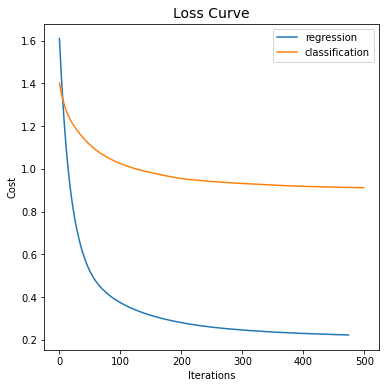

In [107]:
print("erreur : ", 1-nnetOpt.score(Xr_test,Yr_test))

regr = MLPRegressor(random_state=1, max_iter=1500, alpha=nnetOpt.best_params_["alpha"],hidden_layer_sizes=nnetOpt.best_params_["hidden_layer_sizes"]).fit(Xr_train, Yr_train)

plt.plot(regr.loss_curve_, label="regression")
plt.plot(nneclass.loss_curve_, label="classification")
plt.legend()
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

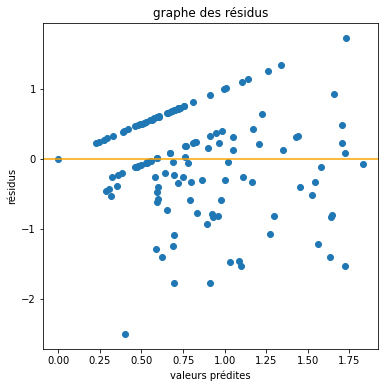

In [108]:
rnnpred=nnetOpt.predict(Xr_test)
rnnres=rnnpred-list(Yr_test)#résidus 
plt.plot(rnnpred,rnnres, "o") 
plt.title ("graphe des résidus")
plt.ylabel("résidus")
plt.xlabel("valeurs prédites")
plt.axhline(c="orange")

In [109]:
print("Erreurs et performance du modèle Réseaux de Neurones pour prédire Rain_mod")
print("-------------------------------------------------------------------")
msernnreg=np.sum(( rnnpred-list(Yr_test))**2) /len(rnnpred) 
print("MSE = ", msernnreg)
print("MAPE= ",MAPE(rnnpred, list(Yr_test)))

Erreurs et performance du modèle Réseaux de Neurones pour prédire Rain_mod
-------------------------------------------------------------------
MSE =  0.5098401048973115
MAPE=  30.48624973249136


# <FONT COLOR="Red">Épisode 4</font>

### [*Support Vector Machine*](http://wikistat.fr/pdf/st-m-app-svm.pdf)

#### Classification 

De nombreux paramètres sont associés à cette méthode. La liste est à consulter dans la [documentation](http://scikit-learn.org/stable/modules/svm.html) en ligne.

L'optimisation de la pénalisation (paramètre C) est recherchée sur une grille par validation croisée. Remarque: il serait nécessaire d'optimiser également la valeur du coefficient *gamma* lié au noyau gaussien ("écart-type").

Il est souvent nécessaire de normaliser des données avant d'opérer les SVM.

In [110]:
y_true = np.array(Yr_test).tolist() #A utiliser pour la fonction MAPE

In [111]:
from sklearn.svm import SVC
param=[{"C":[0.6,0.8,1.35,1.4,1.45,1.8,2.0,2.2]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.436364, Meilleur paramètre = {'C': 0.8}


<FONT COLOR = "blue"> Le meilleur paramètre est C=0.8

In [112]:
# prévision de l'échantillon test
y_chap = svmOpt.predict(Xr_test) # Prédiction
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 
print("Erreurs et performance du modèle SVM pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=",1-svmOpt.score(Xr_test,Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du modèle SVM pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.46376811594202894
pureté= 0.5362318840579711
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          16         7        3
low_rain           16        42       28
no_rain             3         7       16

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.457143
low_rain     0.750000
no_rain      0.340426
dtype: float64


<FONT COLOR = "blue"> **Interprétation matrice de confusion :**
- en colonne : la réalité 
- en ligne la prédiction
    
En comparant les rapports entre les trois lignes, on observe que : 
- Quand on prédit **high_rain** notre modèle basé sur SVM est meilleur que la régression logistique (**cf. autres modèles après avoir fait les épisodes 2 et 3**) car ses prédictions sont correctes dans 60% des cas. Cependant, ce résultat reste faible car il se trompe dans 40% des cas avec la variable **low_rain**. 
- Quand on prédit **low_rain** notre modèle est assez bon car il fournit une prédiction correcte dans 82% des cas. Il éprouve plus de difficultés à décider entre **high_rain** ou **low_rain** lorsque la bonne prédiction est **low_rain**. 
- Quand on prédit **no_rain** notre modèle est mauvais car il ne prédit correctement que 20% des cas. Ce résultat est encore plus mauvais que celui de la régression logistique notamment (**cf. autres modèles après avoir fait les épisodes 2 et 3**).

In [113]:
from sklearn import svm
#LINEAR kernel
param=[{"C":[0.005,0.01,0.02,0.03,0.04,0.05,0.06]}]
svmL= GridSearchCV(svm.SVC(kernel="linear"),param,cv=10,n_jobs=-1)
svmLOpt=svmL.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmLOpt.best_score_,svmLOpt.best_params_))

Meilleur score = 0.429091, Meilleur paramètre = {'C': 0.03}


In [114]:
# erreur test 
y_chap = svmLOpt.predict(Xr_test) # Prédiction
# matrice de confusion
print("score",svmLOpt.score(Xr_test, Yb_test))
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 
print("Erreurs et performance du modèle SVM noyau linéaire pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=",1-svmLOpt.score(Xr_test,Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

score 0.5072463768115942
Erreurs et performance du modèle SVM noyau linéaire pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.49275362318840576
pureté= 0.5072463768115942
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          17         7        4
low_rain           14        44       34
no_rain             4         5        9

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.485714
low_rain     0.785714
no_rain      0.191489
dtype: float64


In [115]:
#POLYNOMIAL kernel
param=[{"C":[0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],"gamma":[0.02,0.04,0.06,0.08,0.1]}]
svm_poly=GridSearchCV(svm.SVC(kernel="poly"),param,cv=10,n_jobs=-1)
svm_polyOpt=svm_poly.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svm_polyOpt.best_score_,svm_polyOpt.best_params_))

Meilleur score = 0.472727, Meilleur paramètre = {'C': 0.03, 'gamma': 0.1}


In [116]:
y_chap = svm_polyOpt.predict(Xr_test) # Prédiction
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 

print("Erreurs et performance du modèle SVM noyau polynomial pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=",1-svm_polyOpt.score(Xr_test,Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du modèle SVM noyau polynomial pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.46376811594202894
pureté= 0.5362318840579711
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          17         8        4
low_rain           18        44       30
no_rain             0         4       13

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.485714
low_rain     0.785714
no_rain      0.276596
dtype: float64


In [117]:
#RADIAL (RBF) kernel
param=[{"C":[0.4,0.5,0.6,0.7,0.8,0.9,10,20,30],"gamma":[0.005,0.01,0.02,0.3,0.4]}]
svm_rbf=GridSearchCV(svm.SVC(kernel="rbf"),param,cv=10,n_jobs=-1)
svm_rbfOpt=svm_rbf.fit(Xr_train, Yb_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svm_rbfOpt.best_score_,svm_rbfOpt.best_params_))

Meilleur score = 0.434545, Meilleur paramètre = {'C': 10, 'gamma': 0.005}


In [118]:
y_chap = svm_rbfOpt.predict(Xr_test) # Prédiction
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test) # Matrice de confusion 

print("Erreurs et performance du modèle SVM noyau gaussien pour prédire Rain_class")
print("-------------------------------------------------------------------")
# erreur sur l'échantillon test
print("erreur sur l'échantillon test=",1-svm_rbfOpt.score(Xr_test,Yb_test))
print("pureté=", purity(table))
print("-------------------------------------------------------------------")
print("table de contingence")
print(table)
print("\n ratio de prédictions correctes par classe :")
print(np.diag(table)/np.sum(table,axis=0))

Erreurs et performance du modèle SVM noyau gaussien pour prédire Rain_class
-------------------------------------------------------------------
erreur sur l'échantillon test= 0.44202898550724634
pureté= 0.5579710144927537
-------------------------------------------------------------------
table de contingence
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          16         7        4
low_rain           15        43       25
no_rain             4         6       18

 ratio de prédictions correctes par classe :
rain_class
high_rain    0.457143
low_rain     0.767857
no_rain      0.382979
dtype: float64


<FONT COLOR = "blue"> D'après les résultats ci-dessous, les meilleurs modèles sont dans l'ordre radial/polynomial puis linéaire. 

**Exercice** Comme précédemment, remplacer ensuite la fonction SVC par celle [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) de régression. Optimiser le paramètre, calculer la prévision, les résidus; le MSE.

#### Régression

In [119]:
from sklearn.svm import SVR
param=[{"C":[0.1,0.2,0.3,0.4,0.5,0.6,0.7],"gamma":[0.005,0.01,0.02,0.3,0.4]}]
svr= GridSearchCV(SVR(),param,cv=10,n_jobs=-1)
svrOpt=svr.fit(Xr_train, Yr_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt.best_score_,svrOpt.best_params_))

Meilleur score = 0.723781, Meilleur paramètre = {'C': 0.6, 'gamma': 0.02}


In [120]:
# prévision de l'échantillon test
y_chap = svrOpt.predict(Xr_test) # Prédiction

In [121]:
#meteo.loc[483]["rain_mod"]
y_true = np.array(Yr_test).tolist()
print('erreurs Python du modèle SVM régression ')
print("--------------------------------------------")
print("erreur généralisation Python =",1-svrOpt.score(Xr_test,Yr_test))
print("MSE=",mean_squared_error(y_chap,Yr_test))
print("MAPE=", MAPE(y_true, y_chap))

erreurs Python du modèle SVM régression 
--------------------------------------------
erreur généralisation Python = 0.6732717639841261
MSE= 0.46725502055643525
MAPE= 33.31114723307034


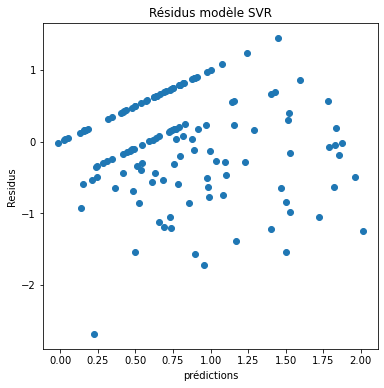

In [122]:
plt.plot(y_chap,y_chap-y_true,"o")
plt.xlabel("prédictions")
plt.ylabel("Residus")
plt.title("Résidus modèle SVR")
plt.show()

## Synthèse: comparaison des méthodes

### Itération sur plusieurs échantillons de test ([validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf))

L'échantillon test est de taille modeste et donc l'estimation de l'erreur de prévision peut présenter une variance importante. Celle-ci est réduite en opérant une forme de validation croisée (*Monte Carlo*) en tirant plusieurs couples d'échantillon apprentissage et test pour itérer les traitements précédents. Les données sont normalisées pour toutes les méthodes car les autres que SVM et NN ne sont pas affectées.

Les fonctionnalités de scikit-learn se prètent bien à l'automatisation de ces traitements enchaînant extraction d'échantillons, estimation de plusieurs modèles, optimisation de leurs paramètres et estimation de l'erreur de prévision sur le test.

Le code est compact et d'exécution efficace car bien parallélisé par les fonctions utilisées.

In [123]:
from sklearn.utils import check_random_state
import time
check_random_state(13)
tps0=time.perf_counter()
# définition des estimateurs
logit= LogisticRegression(penalty="l1",solver="liblinear")
knn  = KNeighborsClassifier()
tree = DecisionTreeClassifier()
nnet = MLPClassifier(max_iter=10000)
rf   = RandomForestClassifier(n_estimators=100)
svm  = SVC()
# Nombre d'itérations
B=30 # pour exécuter après le test, mettre plutôt B=30
# définition des grilles de paramètres0
listMethGrid=[[svm,{"C":[0.4,0.5,0.6,0.8,1,1.4]}],
    [rf,{"max_features":list(range(2,10,2))}],
    [nnet,{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}],
    [tree,{"max_depth":list(range(2,10))}],
    [knn,{"n_neighbors":list(range(1,15))}],
    [logit,{"C":[0.5,1,5,10,12,15,30]}]]
# Initialisation à 0 des erreurs pour chaque méthode (colonne) et chaque itération (ligne)
arrayErreur=np.empty((B,6))
for i in range(B):   # itérations sur B échantillons test
    # extraction apprentissage et test
    X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200)
    scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    # Meme transformation sur le test
    X_test = scaler.transform(X_test)
    # optimisation de chaque méthode et calcul de l'erreur sur le test
    for j,(method, grid_list) in enumerate(listMethGrid):
        methodGrid=GridSearchCV(method,grid_list,cv=10,n_jobs=-1).fit(X_train, Yb_train)
        methodOpt = methodGrid.best_estimator_
        methFit=methodOpt.fit(X_train, Yb_train)
        arrayErreur[i,j]=1-methFit.score(X_test,Yb_test)
        y_chap=methFit.predict(X_test)
tps1=time.perf_counter()
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","NN","Tree","Knn","Logit"])    

/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Temps execution en mn : 1651.3232702700002


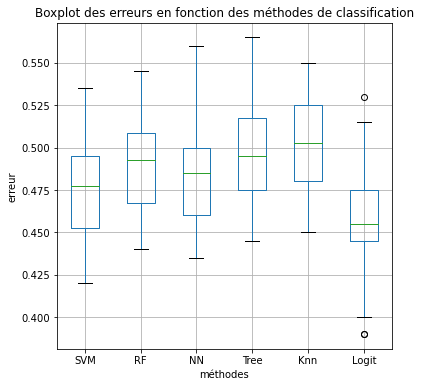

In [124]:
# Distribution des erreurs de prévisions
# Les SVM présentant des erreurs atypiques sont laissés de côté.
dataframeErreur[["SVM","RF","NN","Tree","Knn","Logit"]].boxplot(return_type='dict')
plt.ylabel('erreur')
plt.xlabel('méthodes')
plt.title("Boxplot des erreurs en fonction des méthodes de classification")
plt.show()

Au vu des résultats on choisirait la méthode Logit ou svm

In [125]:
# Moyennes
dataframeErreur.mean()

SVM      0.477833
RF       0.489500
NN       0.485500
Tree     0.495833
Knn      0.500833
Logit    0.456333
dtype: float64

In [126]:
from sklearn.utils import check_random_state
import time
from sklearn.neighbors import KNeighborsRegressor
check_random_state(13)
tps0=time.perf_counter()
# définition des estimateurs
reglasso= linear_model.Lasso()
tree = DecisionTreeRegressor()
nnet = MLPRegressor(max_iter=1000, alpha=5)
rf   = RandomForestRegressor(n_estimators=100)
svm  = SVR()
# Nombre d'itérations
B=30 # pour exécuter après le test, mettre plutôt B=30
# définition des grilles de paramètres0
listMethGrid=[[svm,{"C":[0.4,0.5,0.6,0.8,1,1.4]}],
    [rf,{"max_features":list(range(2,10,2))}],
    
    [nnet,{"hidden_layer_sizes":list([(5,),(6,),(7,),(8,)])}],
    [tree,{"max_depth":list(range(2,10))}],
    [reglasso,{"alpha":[0.01,0.02, 0.025,0.03,0.035, 0.04,0.05,0.1,0.2,0.3,0.4,0.5,1,1.3,1.5,1.6,1.7,1.8,2,4]}]]
# Initialisation à 0 des erreurs pour chaque méthode (colonne) et chaque itération (ligne)
arrayErreur=np.empty((B,5))
arraymape=np.empty((B,5))
for i in range(B):   # itérations sur B échantillons test
    # extraction apprentissage et test
    X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=200)
    scaler = StandardScaler()  
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    # Meme transformation sur le test
    X_test = scaler.transform(X_test)
    # optimisation de chaque méthode et calcul de l'erreur sur le test
    for j,(method, grid_list) in enumerate(listMethGrid):
        methodGrid=GridSearchCV(method,grid_list,cv=10,n_jobs=-1).fit(X_train, Yr_train)
        methodOpt = methodGrid.best_estimator_
        methFit=methodOpt.fit(X_train, Yr_train)
        arrayErreur[i,j]=1-methFit.score(X_test,Yr_test)
        Ypredict=methFit.predict(X_test)
        arraymape[i,j]=MAPE(list(Yr_test), Ypredict)
tps1=time.perf_counter()
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","NN","Tree", "reglasso"])    

KeyboardInterrupt: 

In [ ]:
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arrayErreur,columns=["SVM","RF","NN","Tree", "reglasso"])  
# Distribution des erreurs de prévisions
# Les SVM présentant des erreurs atypiques sont laissés de côté.
dataframeErreur[["SVM","RF","NN","Tree", "reglasso"]].boxplot(return_type='dict')
plt.ylabel('erreur')
plt.xlabel('méthodes régression')
plt.title("Boxplot des erreurs en fonction des méthodes")
plt.show()



MAPE(list(tparome_original), list(meteorain_original))

In [ ]:
print("Temps execution en mn :",(tps1 - tps0))
dataframeErreur=pd.DataFrame(arraymape,columns=["SVM","RF","NN","Tree", "reglasso"])  
# Distribution des erreurs de prévisions
# Les SVM présentant des erreurs atypiques sont laissés de côté.
dataframeErreur[["SVM","RF","NN","Tree",  "reglasso"]].boxplot(return_type='dict')
plt.ylabel('erreur MAPE')
plt.xlabel('méthodes régression')
plt.title("Boxplot des erreurs en fonction des méthodes régression")
plt.show()

print("pour comparaison avec le modèle de prédiction de base de Météo France on voit qu'il y a quand meme une amélioration du MAPE")
MAPE(list(tparome_original), list(meteorain_original))

### Conclusion sur l'apprentissage
**Q** Quel méthode retenir? Est-ce cohérent avec les résultats e R?

Cet exemple, traité en R puis en Python, résume bien l'intérêt et le contexte des méthodes d'apprentissage.
* Par rapport à la *base line* : prévision MOCAGE présentant un taux moyen d'erreur de 30%, un modèle statistique élémentaire améliore très sensiblement le résultat.
* Une méthode plus sophistiquée, ici *SVM* ou *random forest* apporte une amélioration statistiquement significative mais assez faible au prix de l'interprétation fine des résultats fournie par une régression logistique.
* Python, outil d'*apprentissage machine*, est plus efficace que R pour les  simulations.
* En revanche, R, outil d'*apprentissage statistique*, permet la sélection et l'interprétation des variables et de leurs **interactions** pour un modèle de régression linéaire ou logistique classique. La prise en compte d'interactions (modèle quadratique) améliore sensiblement la qualité des prévisions.
* Les forêts aléatoires et les SVM font mieux sur cet exemple, c'est souvent le cas comme avec le *boosting*, mais d'autres exemples mettent en avant d'autres méthodes: neurones pour une modélisation physique, SVM pour du criblage virtuelle de molécules, régression PLS pour la spectrométrie en proche infra-rouge (NIR)... pas de règle générale.
* Jupyter est un support pédagogique efficace pour des analyses sans développement volumineux de code.
* Avant d'éventuellement passer à [Julia](http://julialang.org/), R et Python sont à l'usage très complémentaires.


# <FONT COLOR="Red">Épisode 5</font>
**Remarque** Il est possible d'exécuter directement l'*épisode 5* sans passer par toutes les étapes de classification supervisée. Il suffit d'exécuter jusqu'à la *section 4.1* de l'*épidode 1*, phase exploratoire et préparation des échantillons, afin de construire les données utilisées dans les sections 12 et 13 d'imputation des données manquantes et de détection d'atypiques.

## [Gestion des données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf)
Les vraies données sont le plus souvent mitées par l'absence de données, conséquences d'erreurs de saisie, de pannes de capteurs... Les librairies de Python (`pandas`) offrent des choix rudimentaires pour faire des imputations de données manquantes quand celles-ci le sont de façon complètement aléatoire. 

Le [calepin R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) d'analyse de ces mêmes données propose une comparaison assez détaillée de deux stratégiées afin d'évaluer leurs performances respectives. 

La **première stratégie** commence par imputer les données manquantes en les prévoyant par l'algorithme `missForest`. Une fois les données manquantes imputées, différentes méthodes de prévision sont utilisables comme précédemment. Deux sont exécutées: forêts aléatoires et *extrem gradient boosting*.

La **deuxième stratégie** évite l'étape d'imputation en exécutant directement un algorithme de prévision tolérant des données manquantes. Peu le fond, c'est le cas de `XGBoost`.

Sur ces données, mais sans gros effort d'optimisation de `XGBoost`, la première stratégie enchaînant `missForest` puis `randomForest` conduit à de meilleurs résultats. Seule celle-ci est employée dans ce calepin mais, bien évidemment, l'exécution de `xgboost` sans imputation préalable est une option également possible en Python.

Bien moins de méthodes sont proposées en Python, `SCikit-learn` ne proposant que des imputations basiques par la moyenne ou la médiane comme dans `pandas`. Néanmoins une imputation par prévision utilisant *k*-nn,  ou des forêts aléatoires (Missforest) est disponible dans la librairie `missingpy`.

Les commandes ci-dessous font appel aux fichiers suivants:
- `X` données complètes initiales 
- `Xna` les données avec des trous, 
- `XnaImp` les données avec imputations 


### Préparation des trous dans `ozone`
Les données initiales de la base `ozone` sont reprises. Seule la variable à expliquer de dépassement de seuil est conservée. La première opération consiste à générer aléatoirement un certain taux de données manquantes par la fonction définie ci-dessous.

In [ ]:
import numpy as np
import numpy.ma as ma
import random

def input_nan(x, tx):
    """
    x : a 2D matrix of float dtype
    tx: the rate of nan value to put in the matrix
    """
    n_total = x.shape[0] * x.shape[1]
    mask = np.array([random.random() for _ in range(n_total)]).reshape(x.shape)<tx
    mx = ma.masked_array(x, mask=mask, fill_value=np.nan)
    return mx.filled()

In [ ]:
# données initiales avec 
X=dfC 
# Génération de 10% de valeurs manquantes
Xna=input_nan(X, .1)

### Imputation par `missForest`
Le même algorithme que celui présent dans la librairie de R `MissForest` est implémenté dans la librairie `Scikit-learn`. 

In [ ]:
from missingpy import MissForest
imputer = MissForest()
XnaImp = imputer.fit_transform(Xna)

### Séparation des échantillons
Des cas sont consiédérés: les données sans données manquantes et les données après imputation des données manquantes. Les mêmes échantillons sont considérés en utilisant la même initialisation du générateur.

In [ ]:
# Données sans trous
X_train,X_test,Yb_train,Yb_test=train_test_split(X,Yb,test_size=200,random_state=11)
XnaImp_train,XnaImp_test,Yb_train,Yr_test=train_test_split(XnaImp,Yb,test_size=200,random_state=11)

### Prévision par forêt aléatoire
Prévision du dépassement d'ozone sans données manquantes et avec données manquantes imputées. Comparaison des erreurs de prévision sur l'échantillon test. Les valeurs par défaut des paramètres sont conservées. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
# prévision sans trous
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(X_train,Yb_train)
# erreur de prévision
# erreur de prévision sur le test
1-rfFit.score(X_test,Yb_test)

In [ ]:
# prévision avec trous imputés
forest = RandomForestClassifier(n_estimators=500)
# apprentissage
rfFit = forest.fit(XnaImp_train,Yb_train)
# erreur de prévision
# erreur de prévision sur le test
1-rfFit.score(XnaImp_test,Yb_test)

**Q** Que dire de la qualité de prévision avec 10% de trous

**Exercice** Faire varier le taux de trous et étudier la dégradation de la prévision.

**Exercice** Comparer avec une approche directe de la prévision avec `XGBoost` sans imputation préalable.

# <FONT COLOR="Red">Épisode 5 bis</font>
**Remarque** Il est possible d'exécuter directement l'*épisode 5* sans passer par toutes les étapes de classification supervisée. Il suffit d'exécuter jusqu'à la *section 4.1* de l'*épidode 1*, phase exploratoire et préparation des échantillons, afin de construire les données utilisées dans les sections 6 et 7 d'imputation des données manquantes et de détection d'atypiques.
## Détection d'observations atypiques

Le [calepin R](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb) d'analyse de ces mêmes données propose une comparaison assez détaillée des scores de détection des anomalies. Comme dans R, `Scikit-learn` propose des fonctions en Pyhton de détection d'atypiques multidimensionnels. Les principales sont *LOF* et *Isolation Forest* dont les résultats sont comparés ci-dessous.


### *Local Outlier Factor*
Les données sont restreintes aux seules variables quantitatives explicatives.

**Q** Quel est le rôle du paramètre *k* ci-dessous?

In [ ]:
ozone.head()

In [ ]:
ozoneR=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]
ozoneR.head()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05 ) # choix de n_n par défaut
scoreLOF=clf.fit_predict(ozoneR)
scoreAtyp=-clf._decision_function(ozoneR)# opposé du LOF
plt.boxplot(scoreAtyp)
plt.show()

**Q** Comment se comporte le *LOF* en fonction de *k*?

**Q** Quel taux d'observations par défaut sont considérées comme atypiques?

In [ ]:
atypLofInd = clf.fit_predict(X)

L'analyse en composante principale est utilisée pour représenter les observations atypiques.

In [ ]:
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypLofInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

### *OCC SVM*
**Q** Quels sont les paramètres de cette fonction.

In [ ]:
from sklearn.svm import OneClassSVM
clf=OneClassSVM(nu=0.1, gamma=0.01)
scoreSVM=clf.fit(ozoneR)
scoreAtypSVM=clf._decision_function(ozoneR)
plt.boxplot(scoreAtypSVM)
plt.show()

**Q** Quel taux d'atypiques par défaut?

In [ ]:
atypSVMInd = clf.predict(ozoneR)

In [ ]:
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypSVMInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

### *Isolation forest*
**Q** Comment se mesure l"atypicité" d'une observation dans le cas d'*isolation forest*?

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples=1000, contamination=0.05,behaviour="new")
scoreIF=clf.fit(ozoneR)
scoreAtypIF=clf.decision_function(ozoneR)
plt.boxplot(scoreAtypIF)
plt.show()

In [ ]:
atypIFInd = clf.predict(ozoneR)
## Repésentation des atypiques
plt.figure(figsize=(5,5))
for i, j, nom in zip(C[:,0], C[:,1], atypIFInd):
    color = "red" if nom!=1  else "blue"
    plt.plot(i, j, "o",color=color)
plt.axis((-4,6,-4,6))  
plt.show()

**Q** Les observations définies comme des anomalies se retrouve-t-elles généralement d'une approche à l'autre?

**Remarques**

- la littérature sur la détection d'anomalies ou de nouveautés multidimensionnelles est vaste et fort peu consensuelle. Ceci est encore renforcé par le fait qu'il est difficile de définir un critère efficace de mesure de la qualité d'une détection. Voir à ce sujet l'[article](http://www.dbs.ifi.lmu.de/research/outlier-evaluation/) de Campos et al. (2016).  Il importe donc, en fonctin du cas et des données traitées, de pouvoir disposer d'une "vérité terrain": quelle méthode est le pllus susceptible de retrouver des anomalies identifiées en tant que telle?
- Conrairement à la librairie originale `randomForest` de R, il ne semble pas exister de librairie proposant la détection d'anomalies relativemement à la construction d'un modèle de prévision *y=f(X)* par forêt aléatoire. Il importe de suivre l'évolution des librairies en cours de développement.

## 